# Experimental results for active learning sampling strategies

In [14]:
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [15]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import pickle

In [16]:
%matplotlib inline

In [17]:
import os
import certifi

# Set the REQUESTS_CA_BUNDLE environment variable
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()

# Check the path to the CA certificates bundle
print("CA Certificates Path:", os.environ["REQUESTS_CA_BUNDLE"])

CA Certificates Path: /Users/niek/niek-env/lib/python3.11/site-packages/certifi/cacert.pem


In [18]:
!export REQUESTS_CA_BUNDLE=/etc/ssl/certs/ca-certificates.crt

In [19]:
LIBSVM_URL = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/"
LIBSVM_DOWNLOAD_FN = {
    "rcv1": "rcv1_train.binary.bz2",
    "mushrooms": "mushrooms",
    "a1a": "a1a",
    "a2a": "a2a",
    "ijcnn": "ijcnn1.tr.bz2",
    "w8a": "w8a",
}


def load_mnist(data_dir):
    dataset = MNIST(
        data_dir, train=True, transform=None, target_transform=None, download=True
    )

    X, y = dataset.data.numpy(), dataset.targets.numpy()
    X = X / 255.0
    X = X.reshape((X.shape[0], -1))
    return X, y


def load_libsvm(name, data_dir):
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)

    fn = LIBSVM_DOWNLOAD_FN[name]
    data_path = os.path.join(data_dir, fn)

    if not os.path.exists(data_path):
        url = urllib.parse.urljoin(LIBSVM_URL, fn)
        print("Downloading from %s" % url)

        import ssl

        ssl._create_default_https_context = ssl._create_unverified_context

        urllib.request.urlretrieve(url, data_path)
        print("Download complete.")

    X, y = load_svmlight_file(data_path)
    return X, y

In [20]:
from torch.utils.data import Dataset

def get_dataset(dataset_name, split, datadir, exp_dict):
    train_flag = True if split == 'train' else False
    if dataset_name in ['B', 'C']:
        bias = 1;
        scaling = 10;
        sparsity = 10;
        solutionSparsity = 0.1;
        n = 1000

        if dataset_name == 'C':
            p = 100
        if dataset_name == 'B':
            p = 10000

        A = np.random.randn(n,p)+bias;
        A = A.dot(np.diag(scaling* np.random.randn(p)))
        A = A * (np.random.rand(n,p) < (sparsity*np.log(n)/n));
        w = np.random.randn(p) * (np.random.rand(p) < solutionSparsity);

        b = np.sign(A.dot(w));
        b = b * np.sign(np.random.rand(n)-0.1);
        labels = np.unique(b)
        A = A / np.linalg.norm(A, axis=1)[:, None].clip(min=1e-6)
        A = A * 2
        b[b==labels[0]] = 0
        b[b==labels[1]] = 1

        dataset = torch.utils.data.TensorDataset(torch.FloatTensor(A), torch.FloatTensor(b))

        return DatasetWrapper(dataset, split=split)

    if dataset_name == 'tiny_imagenet':
        if train_flag:
            transform_train = transforms.Compose([
                # transforms.Resize(32),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ])
            # define dataloader
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                        transform=transform_train)

        else:
            transform_test = transforms.Compose([
                # transforms.Resize(32),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                       transform=transform_test)

    if dataset_name == 'imagenette2-160':
        if train_flag:
            transform_train = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                # transforms.RandomResizedCrop(224),
                # transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ])
            # define dataloader
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                        transform=transform_train)

        else:
            transform_test = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                       transform=transform_test)

    if dataset_name == 'imagewoof2-160':
        if train_flag:
            transform_train = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                # transforms.RandomResizedCrop(224),
                # transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ])
            # define dataloader
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                        transform=transform_train)

        else:
            transform_test = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                       transform=transform_test)

    if dataset_name == "mnist":
        view = torchvision.transforms.Lambda(lambda x: x.view(-1).view(784))
        dataset = torchvision.datasets.MNIST(datadir, train=train_flag,
                               download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.5,), (0.5,)),
                                   view
                               ])
                               )

    if dataset_name == "cifar10":
        transform_function = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

        dataset = torchvision.datasets.CIFAR10(
            root=datadir,
            train=train_flag,
            download=True,
            transform=transform_function)

    if dataset_name == "cifar100":
        transform_function = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

        dataset = torchvision.datasets.CIFAR100(
            root=datadir,
            train=train_flag,
            download=True,
            transform=transform_function)

    if dataset_name in ['B', 'C']:
        bias = 1;
        scaling = 10;
        sparsity = 10;
        solutionSparsity = 0.1;
        n = 1000

        if dataset_name == 'C':
            p = 100
        if dataset_name == 'B':
            p = 10000

        A = np.random.randn(n,p)+bias;
        A = A.dot(np.diag(scaling* np.random.randn(p)))
        A = A * (np.random.rand(n,p) < (sparsity*np.log(n)/n));
        w = np.random.randn(p) * (np.random.rand(p) < solutionSparsity);

        b = np.sign(A.dot(w));
        b = b * np.sign(np.random.rand(n)-0.1);
        labels = np.unique(b)
        A = A / np.linalg.norm(A, axis=1)[:, None].clip(min=1e-6)
        A = A * 2
        b[b==labels[0]] = 0
        b[b==labels[1]] = 1
        # squared_max, squared_min = compute_max_eta_squared_loss(A)
        # logistic_max, logistic_min = compute_max_eta_logistic_loss(A)
        dataset = torch.utils.data.TensorDataset(torch.FloatTensor(A), torch.FloatTensor(b))

        return DatasetWrapper(dataset, split=split)


    if dataset_name in ["mushrooms", "w8a",
                        "rcv1", "ijcnn", 'a1a','a2a',
                        "mushrooms_convex", "w8a_convex",
                        "rcv1_convex", "ijcnn_convex", 'a1a_convex'
                        , 'a2a_convex']:

        sigma_dict = {"mushrooms": 0.5,
                      "w8a":20.0,
                      "rcv1":0.25 ,
                      "ijcnn":0.05}

        X, y = load_libsvm(dataset_name.replace('_convex', ''),
                           data_dir=datadir)

        labels = np.unique(y)

        y[y==labels[0]] = 0
        y[y==labels[1]] = 1
        # splits used in experiments
        splits = train_test_split(X, y, test_size=0.2, shuffle=True,
                    random_state=9513451)
        X_train, X_test, Y_train, Y_test = splits

        if "_convex" in dataset_name:
            if train_flag:
                # training set
                X_train = torch.FloatTensor(X_train.toarray())
                Y_train = torch.FloatTensor(Y_train)
                dataset = torch.utils.data.TensorDataset(X_train, Y_train)
            else:
                # test set
                X_test = torch.FloatTensor(X_test.toarray())
                Y_test = torch.FloatTensor(Y_test)
                dataset = torch.utils.data.TensorDataset(X_test, Y_test)

            return DatasetWrapper(dataset, split=split)

        if train_flag:
            # fname_rbf = "%s/rbf_%s_%s_train.pkl" % (datadir, dataset_name, sigma_dict[dataset_name])
            fname_rbf = "%s/rbf_%s_%s_train.npy" % (datadir, dataset_name, sigma_dict[dataset_name])
            if os.path.exists(fname_rbf):
                k_train_X = np.load(fname_rbf)
            else:
                k_train_X = rbf_kernel(X_train, X_train, sigma_dict[dataset_name])
                np.save(fname_rbf, k_train_X)
                print('%s saved' % fname_rbf)

            X_train = k_train_X
            X_train = torch.FloatTensor(X_train)
            Y_train = torch.LongTensor(Y_train)

            dataset = torch.utils.data.TensorDataset(X_train, Y_train)

        else:
            fname_rbf = "%s/rbf_%s_%s_test.npy" % (datadir, dataset_name, sigma_dict[dataset_name])
            if os.path.exists(fname_rbf):
                k_test_X = np.load(fname_rbf)
            else:
                k_test_X = rbf_kernel(X_test, X_train, sigma_dict[dataset_name])
                np.save(fname_rbf, k_test_X)
                print('%s saved' % fname_rbf)

            X_test = k_test_X
            X_test = torch.FloatTensor(X_test)
            Y_test = torch.LongTensor(Y_test)

            dataset = torch.utils.data.TensorDataset(X_test, Y_test)

    if dataset_name == "synthetic":
        margin = exp_dict["margin"]

        X, y, _, _ = make_binary_linear(n=exp_dict["n_samples"],
                                        d=exp_dict["d"],
                                        margin=margin,
                                        y01=True,
                                        bias=True,
                                        separable=exp_dict.get("separable", True),
                                        seed=42)
        # No shuffling to keep the support vectors inside the training set
        splits = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
        X_train, X_test, Y_train, Y_test = splits

        X_train = torch.FloatTensor(X_train)
        X_test = torch.FloatTensor(X_test)

        Y_train = torch.LongTensor(Y_train)
        Y_test = torch.LongTensor(Y_test)

        if train_flag:
            dataset = torch.utils.data.TensorDataset(X_train, Y_train)
        else:
            dataset = torch.utils.data.TensorDataset(X_test, Y_test)

    if dataset_name == "matrix_fac":
        fname = datadir + 'matrix_fac.pkl'
        if not os.path.exists(fname):
            data = generate_synthetic_matrix_factorization_data()
            ut.save_pkl(fname, data)

        A, y = ut.load_pkl(fname)

        X_train, X_test, y_train, y_test = train_test_split(A, y, test_size=0.2, random_state=9513451)

        training_set = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
        test_set = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))

        if train_flag:
            dataset = training_set
        else:
            dataset = test_set

    return DatasetWrapper(dataset, split=split)

class DatasetWrapper:
    def __init__(self, dataset, split):
        self.dataset = dataset
        self.split = split

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data, target = self.dataset[index]


        return {"images":data,
                'labels':target,
                'meta':{'indices':index}}

class NlpDatasetWrapper(Dataset):
    def __init__(self, corpus, data, bptt):
        self.corpus = corpus
        self.data = data
        self.bptt = bptt

    def __len__(self):
        return self.data.size(0) // self.bptt

    def __getitem__(self, index):
        data, targets = nlp_utils.get_batch(self.data, index*self.bptt, self.bptt)

        return {"images":data,
                'labels':targets,
                'meta':{'indices':index}}

def rbf_kernel(A, B, sigma):
    # func = torch.nn.PairwiseDistance(p=2.0, eps=1e-06, keepdim=True)
    # result = func(torch.from_numpy(A.toarray())[None], torch.from_numpy(B.toarray())[None])

    # np.square(metrics.pairwise.pairwise_distances(A.toarray(), B.toarray(), metric="euclidean"))


    # numpy version
    distsq = np.square(metrics.pairwise.pairwise_distances(A, B, metric="euclidean"))
    K = np.exp(-1 * distsq/(2*sigma**2))
    return K

In [21]:
import os
import urllib
import torch

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn import metrics

data = get_dataset("mushrooms", split="train", datadir="~", exp_dict={})
y = np.array([data[i]["labels"].numpy() for i in range(len(data))])
X = np.array([data[i]["images"].numpy() for i in range(len(data))])

data = get_dataset("mushrooms", split="test", datadir="~", exp_dict={})
ytest = np.array([data[i]["labels"].numpy() for i in range(len(data))])
Xtest = np.array([data[i]["images"].numpy() for i in range(len(data))])

In [22]:
X.shape

(6499, 6499)

In [23]:
y.shape

(6499,)

In [164]:
with open('mushroom_train.pkl', 'wb') as f:
    pickle.dump(
        get_dataset("mushrooms", split="train", datadir="~", exp_dict={}),
        f
    )

In [165]:
with open('mushroom_test.pkl', 'wb') as f:
    pickle.dump(
        get_dataset("mushrooms", split="test", datadir="~", exp_dict={}),
        f
    )

# Specify learning algorithms

In [24]:
import math


def sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y


def forward_logloss(X, theta):
    y = np.dot(X, theta.T)
    y = sigmoid(y)
    return y


def forward_squared_hinge(X, theta):
    fwd = np.matmul(X, theta)
    return fwd


def backward_logloss(xx, yy, p):
    grad = (p - yy) * xx
    return grad


def grad_squared_hinge(x, y, theta):
    sy = 2 * y - 1
    grad = -np.max(1 - sy * np.dot(x, theta), 0) * sy * x
    return grad


def cross_entropy(p, y, epsilon=1e-15):
    l = -np.mean(
        y * np.log(np.maximum(p, epsilon))
        + (1 - y) * np.log(np.maximum(1 - p, epsilon))
    )
    return l


def squared_hinge_loss(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    u = p * sy.T
    l = (1 / 2) * np.sum(np.maximum(1 - u, 0) ** 2)
    return l


def accuracy_prob(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p - 1 / 2)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def accuracy_sign(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def sampling(x, a=1):
    return 1


sampling_exp = 0.1


def exp_sampling(x):
    sp = 0
    if x < 1:
        sp = 1 - math.exp(sampling_exp * (x - 1))
    return sp


mu = 1


def uncertainty_sampling(x):
    sp = min(1 / (1 + mu * abs(x)), 1)
    return sp


beta = 1


def squared_hinge_loss_sampling(x):
    x = x[0]
    sp = 0
    if x < 1:
        sp = (beta / 2) * (1 - (cmargin - 1) / (cmargin - x))
    return sp


def ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
    else:
        y = math.exp(u)
    return y


def update(theta, grad, eta=0.01, lam=2):
    newtheta = theta - eta * (grad + 0.5 * lam * theta)
    #  if np.linalg.norm(theta) > 1:
    #    theta = theta / np.linalg.norm(theta)
    return newtheta

In [25]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss
accuracy = accuracy_prob

# CHANGE 4: Moved kappa, kappa0, polyakexp, omega to argument
def train_model(
    X,
    y,
    Xtest,
    ytest,
    mode="rand",
    eta=0.01,
    lam=2,
    # Used in all the Polyak methods
    kappa=1,
    kappa0=0.1,
    # Used in Polyak and Polyak-bec
    polyakexp=1 / 2,
    # Used in polyak-becpi
    omega=1,
    # Added to enable non-adaptive stepsize experiments with pz != 1/2
    pz0 = 1/2,
    # For bec-minx1
    alpha = 1,
    x0 = 1,
    # multiplier to control sampling probability in bec-absloss
    prob_const = 1,
    # debug
    verbose=True,
):
    phi = 2 * np.pi * np.random.rand()
    # theta = np.array([np.cos(phi), np.sin(phi)])
    # theta = np.array([theta_star[0], -theta_star[1]])
    # CHANGE 1: random initialisation is now of shape X.shape[1]
    theta = np.random.rand(X.shape[1])
    stheta = theta

    n_iterations = X.shape[0]  # Number of iterations
    thetas = np.zeros((n_iterations, X.shape[1]))
    
    if verbose:
        print(f"Training with algorithm {mode}: {n_iterations} iterations with d={X.shape[1]}")
        
    losses = np.zeros(n_iterations)
    losses_test = np.zeros(n_iterations)
    slosses_test = np.zeros(n_iterations)
    accuracies = np.zeros(n_iterations)
    accuracies_test = np.zeros(n_iterations)
    saccuracies_test = np.zeros(n_iterations)
    labeled = np.zeros(n_iterations)
    Delta = np.zeros(n_iterations)
    sDelta = np.zeros(n_iterations)
    probs = np.zeros(n_iterations)
    #samples = []

    # CHANGE 2: we loop over the data set size (X.shape[0]) rather than npoints
    # for i in range(npoints):
    for i in range(n_iterations):
        xx = X[i, :]
        yy = y[i]

        p = 0
        q = 0
        pz = 1 / 2
        grad = 0

        thetas[i] = theta
        if mode == "rand":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
        elif mode == "opt":
            raise ValueError(
                "Can't run opt-mode because on real datasets we do not know theta_star!"
            )
            w = 10 * theta_star
            p = forward(xx, theta)
            q = forward(xx, w)
            pz = p * (1 - q) + (1 - p) * q
            grad = backward(xx, yy, p)
        elif mode == "uncertainty":
            w = theta
            p = forward(xx, theta)
            q = forward(xx, w)
            pz = p * (1 - q) + (1 - p) * q
            grad = backward(xx, yy, p)
        elif mode == "squared_hinge":
            p = np.dot(xx, theta)
            pz = sampling((2 * yy - 1) * p)
            grad = grad_squared_hinge(xx, yy, theta)
        elif mode == "polyak":
            p = np.dot(xx, theta)
            grad = grad_squared_hinge(xx, yy, theta)
            #        zeta = min(kappa * loss(p, yy) / (np.linalg.norm(grad)**2), kappa0)
            zeta = min(
                kappa * 1 / (2 * np.linalg.norm(xx) ** 2), kappa0
            )  # squared hinge loss function
            if (2 * yy - 1) * p > 1:
                zeta = 0
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak-becpi":  # binary cross entropy pi sampling
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = omega / (1 + np.exp(u))
            grad = zeta * grad / pz
        elif mode == "polyak-bec-absloss":  # binary cross entropy
            # Hyperparameter tune for different values of polyakexp (including 0), compare to random
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak-rand":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)

            gradient = backward(xx, yy, p)
            theta = update(theta, zeta * gradient)
        elif mode == "bec-absloss":
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = 1 - np.exp(-bec)
            pz = np.min([1, np.max([0, prob_const * pz])])
            grad = backward(xx, yy, p)
        elif mode == "bec-minx1":  
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = np.min([(bec / x0) ** alpha, 1])
            grad = backward(xx, yy, p)
        elif mode == "bec-minx1_default_alpha_x0":  
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = np.min([bec, 1])
            grad = backward(xx, yy, p)
        elif mode == "polyak-bec-minx1":
            # Binary cross-entropy loss with Polyak adaptive step size
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            grad = backward(xx, yy, p)
            
            # Compute pz as in bec-minx1 mode
            pz = np.min([(bec / x0) ** alpha, 1])

            # Compute u and zeta as in polyak-bec mode
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            
            # Compute the gradient of the binary cross-entropy loss with respect to theta
            dL_dpz = -(y / pz - (1 - y) / (1 - pz))
            dL_dbec = 0 if (bec / x0) > 1 else alpha * ((bec / x0) ** (alpha - 1)) / x0

            # Apply the Polyak adaptive step size to the gradient
            scaling_factor = zeta ** (1 - polyakexp)
            grad = scaling_factor * grad

        # sampling
        z = np.random.binomial(1, pz)
        losses[i] = loss(p, yy) + lam * np.linalg.norm(theta)

        #stheta = (1 - 1 / (i + 1)) * stheta + (1 / (i + 1)) * theta
        accuracies[i] = accuracy(p, yy)

        labeled[i] = z
        probs[i] = pz
        # parameter update
        if z > 0:
            theta = update(theta, grad, eta=eta, lam=lam)
            #samples.append(i)

        """
        theta_norm = theta
        if np.linalg.norm(theta)>0:
          theta_norm = theta / np.linalg.norm(theta)
        Delta.append(np.linalg.norm(theta_norm-theta_star))

        stheta_norm = stheta
        if np.linalg.norm(stheta)>0:
          stheta_norm = stheta / np.linalg.norm(stheta)
        sDelta.append(np.linalg.norm(stheta_norm-theta_star))
        """

        p = forward(Xtest, theta)
        losses_test[i] = loss(p, ytest) + lam * np.linalg.norm(theta)
        accuracies_test[i] = accuracy(p, ytest)
        
        """
        p = forward(Xtest, stheta)
        ltest = loss(p, ytest) + lam * np.linalg.norm(stheta)
        slosses_test.append(ltest)
        """
        
        #p = forward(Xtest, theta)

        """
        p = forward(Xtest, stheta)
        a = accuracy(p, ytest)
        saccuracies_test.append(a)
        """

        if verbose and i % 100 == 0:
            print("loss:", losses_test[i], "theta:", theta)

    # CHANGE 3: We write all results to a dict for easier access
    return {
        "losses": losses.tolist(),
        "losses_test": losses_test.tolist(),
        "slosses_test": slosses_test.tolist(),
        "labeled": labeled.tolist(),
        "theta": theta.tolist(),
        #"stheta": stheta,
        "probs": probs.tolist(),
        "accuracies": accuracies.tolist(),
        "accuracies_test": accuracies_test.tolist(),
        "saccuracies_test": saccuracies_test.tolist(),
        #"samples": samples.tolist(),
        "thetas": thetas.tolist(),
    }

# Evaluation



## Run hyperparameter search
Since we do not want to touch the test set that we will use to create our plots (to avoid overfitting on the test set), we split the train set into a train and val set.

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [39]:
trials = {}
best_knowns = {}

In [41]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

import csv
import functools

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
csv_file = os.path.join(notebook_dir, "hyperparam_results_run_optimised_constant_pz_mean_loss.csv")

search_spaces = {
    #"uncertainty": {
    #    'eta': hp.loguniform('eta', -5, -1),
    #    'lam': hp.uniform('lam', 0, 3),
    #},
    #"squared_hinge": {
    #    'eta': hp.loguniform('eta', -5, -1),
    #    'lam': hp.uniform('lam', 0, 3),
    #},
    #"polyak": {
    #    'eta': hp.loguniform('eta', -5, -1),
    #    'lam': hp.uniform('lam', 0, 3),
    #    'kappa': hp.uniform('kappa', 0.5, 3),
    #    'kappa0': hp.loguniform('kappa0', -3, -0.5),
    #},
    "bec-absloss": {
        'eta': hp.loguniform('eta', -5, -1),
        'lam': hp.uniform('lam', 0, 3),
    },
    "rand": {
        'eta': hp.loguniform('eta', -5, -1),
        'lam': hp.uniform('lam', 0, 3),
        # pz0=0.5 yields E[pz] = 0.5
        'pz0': 0.5
    },
    "polyak-bec-absloss": {
        'eta': hp.loguniform('eta', -5, -1),
        'lam': hp.uniform('lam', 0, 3),
        'kappa': hp.uniform('kappa', 0.5, 3),
        'kappa0': hp.loguniform('kappa0', -3, -0.5),
        # Derived by hand analytically that 0.272 yields E[pz] = 0.5
        'polyakexp': 0.272
    },
    #"polyak-becpi": {
    #    'eta': hp.loguniform('eta', -5, -1),
    #    'lam': hp.uniform('lam', 0, 3),
    #    'kappa': hp.uniform('kappa', 0.5, 3),
    #    'kappa0': hp.loguniform('kappa0', -3, -0.5),
    #},
    "polyak-rand": {
        'eta': hp.loguniform('eta', -5, -1),
        'lam': hp.uniform('lam', 0, 3),
        'kappa': hp.uniform('kappa', 0.5, 3),
        'kappa0': hp.loguniform('kappa0', -3, -0.5),
        # Under bec-absloss, E[pz] = 0.5
        # Under polyak-bec-absloss, E[pz] = 0.5 for polyakexp 0.272
        # Under rand with pz0=0.5, E[pz] = 0.5
        # Hence, under polyak-rand with pz=0.5, E[pz] = 0.5 should also be 0.272 under pz0=0.5 
        'pz0': 0.5,
        'polyakexp': 0.272
    },
} 

# Create a Trials object to store optimization results
def create_trial(row):
    # Extract hyperparameter values
    hyperparameters = {param: row[param] for param in param_columns}
    
    # Define the trial dictionary
    trial = {
        'result': {
            'loss': row[loss_column],
            'status': STATUS_OK,
        },
        'misc': {
            'vals': hyperparameters,
            'idxs': {param: [0] for param in param_columns},
        },
    }
    
    return trial

for method in search_spaces:
    if method not in trials:
        trials[method] = Trials()
    if method not in best_knowns:
        best_loss = float('inf')
        best_knowns[method] = {
            "best_loss": best_loss,
            "best_params": None
        }
    """
    existing_runs = hyperparam_results[hyperparam_results.algorithm == method].reset_index()
    print(f"Prepopulating {method}")
    
    for idx, row in existing_runs.iterrows():
        # Extract hyperparameters from the dictionary column
        hyperparameters = eval(row.hyperparams)

        # Define the trial dictionary
        trial = {
            'tid': idx, 
            'state': STATUS_OK,
            'result': {
                'loss': row.loss,
                'status': STATUS_OK,
            },
            'misc': {
                'vals': hyperparameters,
                'idxs': {param: [0] for param in hyperparameters.keys()},
                'cmd': None,
                'tid': idx,
            },
            'spec': None,
            'owner': None,
            'book_time': None,
            'refresh_time': None,
            'exp_key': None,
        }

        print(f"Adding trial {trial}")
        # Add the trial to the Trials object
        trials[method].insert_trial_doc(trial)
        if row.loss < best_loss:
            best_loss = row.loss
        """

# Define the original function with all arguments
def train_and_get_last_loss(X, y, Xtest, ytest, mode, params):
    d = train_model(X, y, Xtest, ytest, mode=mode, verbose=False, **params)
    
    current_loss = np.mean(d["losses_test"])
    
    if current_loss < best_knowns[method]["best_loss"]:
        best_knowns[method]["best_loss"] = current_loss
        best_knowns[method]["best_params"] = params
        print("New best parameters:", best_knowns[method]["best_params"])

    with open(csv_file, 'a', newline='') as file:
        writer = csv.writer(file, delimiter='\t')

        if not os.path.exists(csv_file):
            writer.writerow(['Method', 'Best Loss', 'Best Params'])  # Write header if file doesn't exist

        writer.writerow([method, current_loss, params])

    return current_loss

# Fix some arguments using functools.partial

for method in search_spaces:
    print(f"Tuning for {method}")
    get_loss_after_training = functools.partial(
        train_and_get_last_loss,
        X_train, y_train, X_val, y_val, method
    )

    # Perform hyperparameter optimization using Hyperopt
    best = fmin(
        fn=get_loss_after_training,
        space=search_spaces[method],
        algo=tpe.suggest,
        max_evals=50,
        trials=trials[method],
    )
    print(f"Finished tuning for {method}")
    print()


Tuning for bec-absloss
New best parameters:                                                                                                                                        
{'eta': 0.008552790070518054, 'lam': 1.789761027442016}                                                                                                     
New best parameters:                                                                                                                                        
{'eta': 0.023988074108983175, 'lam': 0.6699381359314639}                                                                                                    
New best parameters:                                                                                                                                        
{'eta': 0.040450291203681425, 'lam': 1.1559627512072124}                                                                                                    
New best parameters:               

## Use best hyperparams to construct plot
Now that we found the best hyperparameters, we compare the test set performance of each learning algorithm when training on the full train set (train + val).

In [42]:
hyperparam_results = pd.read_csv("hyperparam_results_run_optimised_constant_pz_mean_loss.csv", delimiter="\t", header=None)
hyperparam_results.columns = ["algorithm", "loss", "hyperparams"]

In [43]:
min_losses = pd.DataFrame(hyperparam_results.groupby("algorithm").loss.min()).reset_index()

In [45]:
best_hyperparams = min_losses.merge(hyperparam_results, on=["algorithm", "loss"], how="left")

In [46]:
import ast

hyperparam_per_algo = {
    algorithm: ast.literal_eval(hyperparam) for 
    algorithm, hyperparam in 
    zip(best_hyperparams["algorithm"], best_hyperparams["hyperparams"])
}

In [47]:
hyperparam_per_algo

{'bec-absloss': {'eta': 0.3673178111075501, 'lam': 0.009441653430954586},
 'polyak-bec-absloss': {'eta': 0.09312331696386106,
  'kappa': 2.1837919182992165,
  'kappa0': 0.3954485301586105,
  'lam': 0.000317028412895555,
  'polyakexp': 0.272},
 'polyak-rand': {'eta': 0.029094703304065526,
  'kappa': 1.1891488252453413,
  'kappa0': 0.08029253979683175,
  'lam': 0.0004301306441182873,
  'polyakexp': 0.272,
  'pz0': 0.5},
 'rand': {'eta': 0.2312716035230363, 'lam': 0.0016986356026688076, 'pz0': 0.5}}

In [40]:
hyperparam_per_algo

{'bec-absloss': {'eta': 0.013248373097334717, 'lam': 0.5},
 'bec-minx1': {'alpha': 2.098427278879104,
  'eta': 0.27652532883487185,
  'lam': 0.011196406466690512,
  'x0': 0.33954756430524935},
 'bec-minx1_default_alpha_x0': {'eta': 0.03596929644190719,
  'lam': 0.13648182175518075},
 'polyak': {'eta': 0.008599419678542278,
  'kappa': 2.0704040648090043,
  'kappa0': 0.06630216874058997,
  'lam': 1.8242754144654705},
 'polyak-bec': {'eta': 0.029848338795592875,
  'kappa': 1.5,
  'kappa0': 0.0776871329078532,
  'lam': 0.5},
 'polyak-becpi': {'eta': 0.006764676388466573,
  'kappa': 2.0,
  'kappa0': 0.06632889103341866,
  'lam': 2.5},
 'polyak-rand': {'eta': 0.018064517664446448,
  'kappa': 2.2111402564796174,
  'kappa0': 0.4201959587039076,
  'lam': 0.0060769006759058275},
 'rand': {'eta': 0.014942622961058376, 'lam': 0.5},
 'squared_hinge': {'eta': 0.010516324395787422, 'lam': 0.5},
 'uncertainty': {'eta': 0.006984112970608457, 'lam': 1.5}}

In [49]:
polyak_exps = list(range(10))
polyak_strs = [f"0.{elem}" for elem in polyak_exps]
polyak_exps = [eval(elem) for elem in polyak_strs]
polyak_exps

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

## Bec-absloss with Polyak

In [50]:
# Run this cell only if ~/workspace/milan_paper/polyak_becs_uniform.csv doesn't yet exist
polyak_bec_params = hyperparam_per_algo["polyak-bec-absloss"]

polyak_becs2 = {
    f"polyak_bec_{polyak_str}": train_model(
        X, y, Xtest, ytest, mode="polyak-bec-absloss", verbose=True, **(polyak_bec_params | {"polyakexp": polyak_exp})
    )
    for polyak_str, polyak_exp in zip(polyak_strs, polyak_exps)
}

Training with algorithm polyak-bec-absloss: 6499 iterations with d=6499
loss: 0.7072295432690175 theta: [0.54259937 0.71060841 0.0726463  ... 0.87556357 0.35050209 0.17610471]
loss: 0.7071735064302056 theta: [0.5418042  0.68354679 0.05309239 ... 0.8742778  0.34997832 0.17583001]
loss: 0.7071212218849913 theta: [0.54100887 0.68252395 0.05256844 ... 0.87298819 0.34946181 0.17556135]
loss: 0.7070687314783524 theta: [0.54022375 0.68151701 0.0524754  ... 0.87170048 0.34894619 0.17528678]
loss: 0.7070105120880416 theta: [0.53943707 0.68051127 0.05238883 ... 0.87041475 0.34794853 0.17403803]
loss: 0.7069566029402549 theta: [0.53864146 0.67948934 0.05229455 ... 0.86913996 0.34743529 0.17376463]
loss: 0.7069044075055291 theta: [0.53784715 0.67848672 0.05221711 ... 0.867858   0.3469228  0.17349962]
loss: 0.706849919042885 theta: [0.53731072 0.67702066 0.05213994 ... 0.86658204 0.34640381 0.17324309]
loss: 0.7067977517871548 theta: [0.53652292 0.67602126 0.05203912 ... 0.86589162 0.34589256 0.172

loss: 0.7067358242517902 theta: [0.58771643 0.77364795 0.85278886 ... 0.89652745 0.21041657 0.50197622]
loss: 0.7066858409123428 theta: [0.58688928 0.77255223 0.85157357 ... 0.89526318 0.20969991 0.50126487]
loss: 0.7066350022510277 theta: [0.58610158 0.77150575 0.8504212  ... 0.8940616  0.20899529 0.50059129]
loss: 0.7065845327524655 theta: [0.58531497 0.77046016 0.84882906 ... 0.89286143 0.20871474 0.4999191 ]
loss: 0.706537025307324 theta: [0.58453474 0.76940794 0.84714608 ... 0.89166285 0.2084248  0.4992392 ]
loss: 0.7064854611866509 theta: [0.58404535 0.76840898 0.84604601 ... 0.89050543 0.2081468  0.49859095]
loss: 0.7064369982040586 theta: [0.58328745 0.76737437 0.84493964 ... 0.88934948 0.20735553 0.49793296]
loss: 0.7063858409828379 theta: [0.58247866 0.76631001 0.84333542 ... 0.8881164  0.207068   0.49724223]
loss: 0.7063344849026225 theta: [0.58168846 0.76526957 0.84219023 ... 0.88691121 0.20677833 0.49655843]
loss: 0.7062888444151917 theta: [0.58099096 0.76433237 0.84115866

loss: 0.7061369949848932 theta: [0.54979913 0.54575179 0.67461106 ... 0.43729936 0.28274426 0.84328177]
loss: 0.7060881868727388 theta: [0.54913417 0.54507365 0.67378663 ... 0.43713689 0.28239221 0.84181195]
loss: 0.7060406650464602 theta: [0.54844988 0.54438961 0.67293032 ... 0.43658897 0.28202916 0.84016805]
loss: 0.7059877641277911 theta: [0.54813902 0.54369841 0.67206648 ... 0.43603529 0.28167116 0.83909385]
loss: 0.7059419202412524 theta: [0.54743572 0.54299223 0.67120378 ... 0.43547994 0.28130947 0.83800665]
loss: 0.7058920671607227 theta: [0.54679668 0.54234042 0.67041121 ... 0.4349661  0.28097747 0.8369998 ]
loss: 0.7058468979336585 theta: [0.54619175 0.54173997 0.66965817 ... 0.43483584 0.28065816 0.83606464]
loss: 0.7057993634794796 theta: [0.54555538 0.54110765 0.66887731 ... 0.43433404 0.28033106 0.83508985]
loss: 0.7057551901467315 theta: [0.54491151 0.54045995 0.66808738 ... 0.43382144 0.28000002 0.8341039 ]
loss: 0.7057000722753883 theta: [0.54426036 0.53981392 0.6672780

loss: 0.7050952527628374 theta: [0.7424179  0.16977354 0.14469081 ... 0.38843204 0.6172229  0.59743087]
loss: 0.7050445743920334 theta: [0.74151521 0.16893671 0.14451323 ... 0.38795642 0.61646678 0.59669859]
loss: 0.7049964505307056 theta: [0.74067951 0.16874462 0.14380734 ... 0.38751571 0.61575545 0.59600913]
loss: 0.7049499545710696 theta: [0.73981628 0.16851629 0.14363951 ... 0.3870642  0.61503759 0.59531396]
loss: 0.7049010753344395 theta: [0.73892146 0.16831201 0.14345351 ... 0.38660292 0.61429357 0.59459341]
loss: 0.7048554079741128 theta: [0.73806041 0.16809469 0.14325326 ... 0.38615235 0.61357744 0.59389926]
loss: 0.704814722576866 theta: [0.73764743 0.16790869 0.14309474 ... 0.38572518 0.61289834 0.59324194]
loss: 0.7047638389615751 theta: [0.73680476 0.1677153  0.1429211  ... 0.38528132 0.61219305 0.59196608]
loss: 0.7047169269440374 theta: [0.73589641 0.16694614 0.14272287 ... 0.38480388 0.6114341  0.59123232]
loss: 0.7046727567986906 theta: [0.73513651 0.16676413 0.14255538

loss: 0.7044973523165311 theta: [0.70140442 0.42247788 0.48905221 ... 0.10671154 0.87290821 0.63157796]
loss: 0.7044528296289718 theta: [0.70076278 0.42209139 0.48859447 ... 0.10661392 0.872097   0.63099951]
loss: 0.7044067996401153 theta: [0.70000805 0.42163656 0.48806822 ... 0.10651195 0.87115774 0.63028596]
loss: 0.7043500913220114 theta: [0.69922345 0.420585   0.48752079 ... 0.10639266 0.87016957 0.62955861]
loss: 0.7043096370529071 theta: [0.69851162 0.41951968 0.48702426 ... 0.10628444 0.8692835  0.62891751]
loss: 0.7042748005386248 theta: [0.69791397 0.41915062 0.48660701 ... 0.10619349 0.86853957 0.62837927]
loss: 0.7042342393586009 theta: [0.6971829  0.4187001  0.48609689 ... 0.10608238 0.86762956 0.62772079]
loss: 0.7041896266699086 theta: [0.69646287 0.41825512 0.48558217 ... 0.10597282 0.86673349 0.62706185]
loss: 0.7041482398907374 theta: [0.69576597 0.41781746 0.48508762 ... 0.10586514 0.86585113 0.62641409]
loss: 0.7041024603644354 theta: [0.69503715 0.41737939 0.4845687

loss: 0.7065429457622455 theta: [0.90241806 0.94272888 0.91910023 ... 0.73651377 0.2218393  0.34612258]
loss: 0.7064940035503883 theta: [0.90162601 0.9418938  0.91828631 ... 0.73586192 0.22164291 0.34426445]
loss: 0.7064518155299998 theta: [0.90085451 0.94107406 0.91748455 ... 0.73524179 0.22145323 0.3439402 ]
loss: 0.7064003137988657 theta: [0.90001736 0.94019875 0.91663115 ... 0.73455835 0.22124737 0.3436086 ]
loss: 0.7063633887836614 theta: [0.89937584 0.93951871 0.91596812 ... 0.73402735 0.22107219 0.34335971]
loss: 0.7063226472328641 theta: [0.89864152 0.93874167 0.91519772 ... 0.73439612 0.22088952 0.34307572]
loss: 0.7062769681098968 theta: [0.89838963 0.93795166 0.9144152  ... 0.7341974  0.22070372 0.34278665]
loss: 0.7062282244823986 theta: [0.89766055 0.93649719 0.91365912 ... 0.73361189 0.22052412 0.34250843]
loss: 0.7061886585285153 theta: [0.8973811  0.93566678 0.91290347 ... 0.7330057  0.2203419  0.34222516]
loss: 0.7061423985966788 theta: [0.8965869  0.93482602 0.9120950

loss: 0.7059646006149667 theta: [ 0.48977164  0.83178494 -0.001157   ...  0.76352721  0.38261087
  0.51022057]
loss: 0.7059185150978243 theta: [ 0.48933416  0.83100934 -0.00203803 ...  0.76282874  0.38224696
  0.50975349]
loss: 0.7058719265955993 theta: [ 0.48896592  0.83038371 -0.00203679 ...  0.76225467  0.38194708
  0.50935607]
loss: 0.705825596325202 theta: [ 0.48856214  0.82966914 -0.0020351  ...  0.76162482  0.3816171
  0.50893455]
loss: 0.7057762047633797 theta: [ 0.48812241  0.82892213 -0.00205019 ...  0.76093946  0.38127362
  0.50847615]
loss: 0.7057348632702619 theta: [ 0.48775508  0.82829767 -0.0020489  ...  0.76036681  0.38098669
  0.50809323]
loss: 0.7056943269428938 theta: [ 0.4874172   0.82767404 -0.00204737 ...  0.75979475  0.38068714
  0.50771001]
loss: 0.7056637597463642 theta: [ 0.4871223   0.82717326 -0.00204613 ...  0.75933517  0.3804565
  0.5074025 ]
loss: 0.705621975166113 theta: [ 0.48675572  0.82573276 -0.00206033 ...  0.75876373  0.38017018
  0.50699329]
loss:

loss: 0.7055883765011912 theta: [0.87459967 0.21716394 0.88178768 ... 0.77655176 0.92955974 0.35995099]
loss: 0.705553862686257 theta: [0.87451394 0.21703894 0.88127986 ... 0.77656305 0.92902445 0.3597432 ]
loss: 0.7055073736717804 theta: [0.87384988 0.21685517 0.88058557 ... 0.77596739 0.92829308 0.35946714]
loss: 0.7054637707517367 theta: [0.87319226 0.21592949 0.87992166 ... 0.77538359 0.92759419 0.3591966 ]
loss: 0.7054158913956466 theta: [0.87252018 0.21575976 0.87921926 ... 0.77477733 0.92686842 0.3589003 ]
loss: 0.705379831191581 theta: [0.87194093 0.21559912 0.87863506 ... 0.77426285 0.92625235 0.35864272]
loss: 0.7053317480239946 theta: [0.87128036 0.21541869 0.8779606  ... 0.77366875 0.92554163 0.35833218]
loss: 0.7052850226879936 theta: [0.87059916 0.21524988 0.877273   ... 0.77361147 0.92480365 0.35805167]
loss: 0.7052464257359421 theta: [0.86993128 0.21508413 0.87659985 ... 0.77302686 0.92409404 0.35777694]
loss: 0.7052041858246949 theta: [0.86934078 0.21491886 0.87600411 

loss: 0.7054530509305158 theta: [0.12960019 0.03331402 0.7239848  ... 0.02091428 0.45044485 0.00239496]
loss: 0.7054165037825857 theta: [0.12951068 0.03327154 0.72346191 ... 0.02090885 0.45013244 0.00239329]
loss: 0.7053755624138114 theta: [0.12943401 0.03324852 0.72298148 ... 0.02089497 0.44983353 0.00239066]
loss: 0.7053437220122344 theta: [0.129354   0.03322759 0.72251847 ... 0.02088202 0.44955472 0.00237416]
loss: 0.70530139596114 theta: [0.12926239 0.03320335 0.72200669 ... 0.02087885 0.44923631 0.00237246]
loss: 0.7052725530165126 theta: [0.12919958 0.03318717 0.72165506 ... 0.02086869 0.44901752 0.00237098]
loss: 0.7052409684718064 theta: [0.12912923 0.0331493  0.72124218 ... 0.02085729 0.44877235 0.00236872]
loss: 0.7052012218162595 theta: [0.12979407 0.0331263  0.72074195 ... 0.02085395 0.4484611  0.00236708]
loss: 0.7051551565337797 theta: [0.12969448 0.03310087 0.72018862 ... 0.02083795 0.44811699 0.00141515]
loss: 0.7051128220683318 theta: [0.12962071 0.03307783 0.71966985 

In [51]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
polyakbec_results_file = os.path.join(notebook_dir, "polyak_bec_results_constant_pz_mean_loss.pkl")

with open(polyakbec_results_file, "wb") as f:
    pickle.dump(polyak_becs2, f)

In [48]:
#notebook_dir = os.path.dirname(os.path.abspath("__file__"))
#polyakbec_results_file = os.path.join(notebook_dir, "polyak_bec_results_constant_pz_mean_loss.pkl")

#with open(polyakbec_results_file, "rb") as f:
#    polyak_becs2 = pickle.load(f)

## Random baseline

In [52]:
# Set the random parameter p in Bernoulli(p) equal to the average
# pz values of bec-absloss with Polyak (under different polyakexp).
# For comparable results.

d_probs = [
    1.0, 
    0.7745240529580663, 
    0.5998875086105894, 
    0.46462730448799056, 
    0.3598650229870199, 
    0.27872411612175435, 
    0.21587853207577587, 
    0.16720311560996784, 
    0.12950283476944838, 
    0.10030306045519194
]

In [53]:
rand_params = hyperparam_per_algo["rand"]

rand_results = {
    f"rand_{polyak_str}": train_model(
        X, y, Xtest, ytest, mode="rand", verbose=True, **(rand_params | {"pz0": d_prob})
    )
    for polyak_str, d_prob in zip(polyak_strs, d_probs)
}

Training with algorithm rand: 6499 iterations with d=6499
loss: 0.7716518144676089 theta: [1.04434645 0.13438415 0.61192124 ... 0.97754491 0.34746683 0.07442611]
loss: 0.7698539238051811 theta: [1.02406037 0.00195099 0.44872177 ... 0.95856116 0.34065153 0.07288022]
loss: 0.7681553599442718 theta: [1.00417347 0.00181998 0.4376401  ... 0.93991472 0.33402339 0.07141703]
loss: 0.7664477098851502 theta: [0.98471958 0.00178351 0.429037   ... 0.92163098 0.32752488 0.06993045]
loss: 0.7647355202125328 theta: [0.96562645 0.00174609 0.42064146 ... 0.90370335 0.31813389 0.06312457]
loss: 0.7631302423806237 theta: [0.94684298 0.0016119  0.41236203 ... 0.88618887 0.31194538 0.06180763]
loss: 0.7615673624316407 theta: [0.92842541 0.00157897 0.40433856 ... 0.86895064 0.30587724 0.06055537]
loss: 0.7599897184445716 theta: [ 0.91176383 -0.00109741  0.39647221 ...  0.85208409  0.29987291
  0.05937366]
loss: 0.7584652755984864 theta: [ 0.89405113 -0.00108066  0.38862017 ...  0.84043329  0.29403789
  0.05

loss: 0.7589957696320851 theta: [ 0.54391977  0.46099772 -0.09013099 ...  0.09585019  0.20420187
  0.54375173]
loss: 0.7576867325231874 theta: [ 0.53501814  0.45056787 -0.0887051  ...  0.09430547  0.20085828
  0.53485269]
loss: 0.7565305675038116 theta: [ 0.52831641  0.4436669  -0.08735901 ...  0.09287149  0.19780409
  0.52671734]
loss: 0.7552918965785242 theta: [ 0.51967215  0.43635524 -0.08593038 ...  0.09135159  0.19451649
  0.51809534]
loss: 0.7541097825259937 theta: [ 0.51126887  0.42925276 -0.0846427  ...  0.08987482  0.19137066
  0.50966426]
loss: 0.7530129988804263 theta: [ 0.50332407  0.42255866 -0.08337164 ...  0.08850136  0.18582265
  0.50171535]
loss: 0.7519066186479937 theta: [ 0.49547699  0.41591625 -0.08207358 ...  0.08712191  0.18038464
  0.49388967]
loss: 0.7508821041004071 theta: [ 0.48803881  0.40962544 -0.08084246 ...  0.08581402  0.17767665
  0.48647441]
loss: 0.7498091033369231 theta: [ 0.4800527   0.40283522 -0.08232343 ...  0.08440962  0.17476884
  0.47851208]
l

loss: 0.7531218195472504 theta: [ 0.64671588  0.00087197 -0.01073261 ...  0.40263753  0.51176652
  0.30623169]
loss: 0.7521915119285126 theta: [ 0.63838683  0.00075905 -0.01064676 ...  0.3974514   0.5027237
  0.30223568]
loss: 0.7513326648840776 theta: [ 0.63065881  0.00074805 -0.01344958 ...  0.39264047  0.49663793
  0.29857689]
loss: 0.7504177514278294 theta: [ 0.62253562  0.0007374  -0.01327796 ...  0.38758318  0.49018802
  0.29468488]
loss: 0.7496852200609543 theta: [ 0.61612524  0.00072876 -0.01314141 ...  0.3835699   0.48511093
  0.29163089]
loss: 0.7489421037672065 theta: [ 0.60926486  0.0007206  -0.01299588 ...  0.37929894  0.47970934
  0.28838281]
loss: 0.7481728841477686 theta: [ 0.60212642 -0.00173106 -0.01294115 ...  0.37485456  0.47408839
  0.28489835]
loss: 0.7473835597361522 theta: [ 0.59483849 -0.0017597  -0.01278616 ...  0.37031674  0.46834851
  0.28140576]
loss: 0.7466735869369951 theta: [ 0.5883323  -0.00174132 -0.01264631 ...  0.3662653   0.46322362
  0.27827965]
lo

loss: 0.7504299585695969 theta: [0.67978638 0.26458247 0.05773705 ... 0.73773567 0.18932857 0.30248736]
loss: 0.7498390175858097 theta: [0.67399866 0.26230446 0.05724012 ... 0.73138769 0.18769916 0.29983109]
loss: 0.7492704495536967 theta: [0.66806751 0.25999592 0.05673559 ... 0.72495081 0.18604634 0.29719054]
loss: 0.7486287864659371 theta: [0.66156855 0.25745471 0.05618005 ... 0.71786511 0.18422792 0.29419178]
loss: 0.7480988485198367 theta: [0.65639096 0.25539312 0.05569509 ... 0.71224646 0.18278599 0.29188834]
loss: 0.7475164048193227 theta: [0.65048742 0.25309476 0.05519314 ... 0.70587284 0.18114171 0.28926182]
loss: 0.7468475872027484 theta: [0.64375006 0.25042778 0.05462062 ... 0.69856182 0.17926553 0.28626487]
loss: 0.746148418311562 theta: [0.63745803 0.24797922 0.05403868 ... 0.69173405 0.1774616  0.28346591]
loss: 0.7454624767398771 theta: [0.63063509 0.24526305 0.05345631 ... 0.6843011  0.17555457 0.28037464]
loss: 0.744983905713478 theta: [0.62569978 0.24334175 0.0529956  

loss: 0.7488319470917835 theta: [0.2921281  0.58710282 0.00279624 ... 0.0947491  0.66930028 0.70227498]
loss: 0.7484218091646211 theta: [0.29035454 0.58353739 0.00277923 ... 0.09610069 0.66523682 0.69800977]
loss: 0.747864587198487 theta: [0.28796882 0.57874268 0.00275636 ... 0.09534021 0.6597708  0.69227366]
loss: 0.7474146931594933 theta: [0.28594058 0.57466429 0.00263749 ... 0.09466836 0.65512141 0.68739269]
loss: 0.7469356301928055 theta: [0.28555625 0.57061459 0.00261888 ... 0.09403327 0.65050383 0.68254861]
loss: 0.7463545771760712 theta: [0.28315431 0.56581309 0.00254953 ... 0.09324232 0.64503215 0.67675526]
loss: 0.745774123172216 theta: [0.28071747 0.56094088 0.00243194 ... 0.09243986 0.63948086 0.67092997]
loss: 0.7452980438881794 theta: [0.27862977 0.55672034 0.00236505 ... 0.09175238 0.63472326 0.66593947]
loss: 0.7448482396340509 theta: [0.27677499 0.55301338 0.00234926 ... 0.09114161 0.63049721 0.66150377]
loss: 0.7444191185130132 theta: [0.27482504 0.54911472 0.00229132 

loss: 0.7467834958856725 theta: [0.72799863 0.27989153 0.01137266 ... 0.2929862  0.16145851 0.08685913]
loss: 0.7464897337493599 theta: [0.72471683 0.27862977 0.01132059 ... 0.29166657 0.16073066 0.08646605]
loss: 0.7460925167792474 theta: [0.72017543 0.27688285 0.01124965 ... 0.28983886 0.15972345 0.08592415]
loss: 0.7457918564506868 theta: [0.71664843 0.27552637 0.01119279 ... 0.28841894 0.15894096 0.08550319]
loss: 0.7454479424340513 theta: [0.71229806 0.2738526  0.01112482 ... 0.2866679  0.157976   0.08498406]
loss: 0.7450548662716123 theta: [0.70797356 0.27218997 0.01105726 ... 0.28492748 0.15701689 0.08446714]
loss: 0.7445906017258297 theta: [0.70257102 0.27011262 0.01097287 ... 0.2827536  0.15581854 0.08382243]
loss: 0.7442265483974577 theta: [0.69871721 0.26862939 0.01087267 ... 0.28120261 0.15492464 0.08331136]
Training with algorithm rand: 6499 iterations with d=6499
loss: 0.7720731809555804 theta: [0.09988316 0.34760727 0.25357679 ... 0.49672274 0.00398754 0.45707402]
loss: 

loss: 0.7707770423321921 theta: [0.96019872 0.24737614 0.14556073 ... 0.09706079 0.40707603 0.49177103]
loss: 0.7704825949801202 theta: [0.95699748 0.2465514  0.14507543 ... 0.0967372  0.40571885 0.49013149]
loss: 0.7702180620423325 theta: [0.95403129 0.24577682 0.14457265 ... 0.09643362 0.40444565 0.4857259 ]
loss: 0.7698789093637236 theta: [0.95047767 0.24486015 0.14398413 ... 0.09607436 0.40293891 0.48386393]
loss: 0.7694975222901995 theta: [0.94637882 0.24380421 0.14336321 ... 0.09566005 0.40120126 0.48171938]
loss: 0.7691896723461253 theta: [0.94322364 0.24025886 0.14288521 ... 0.09534172 0.39986367 0.48011333]
loss: 0.7689046458114566 theta: [0.94026424 0.23950405 0.14243682 ... 0.09504252 0.39860884 0.47860665]
loss: 0.7685799097791541 theta: [0.93694537 0.23865864 0.14193232 ... 0.09619795 0.39720185 0.47691628]
loss: 0.7681218534065373 theta: [0.93235526 0.23743911 0.14119029 ... 0.09572668 0.39525595 0.47457979]
loss: 0.767766917481862 theta: [0.92833458 0.23641434 0.14058142

loss: 0.7684060214755188 theta: [0.22025376 0.92293639 0.50618351 ... 0.9082246  0.28307265 0.37513712]
loss: 0.7681738402644651 theta: [0.21960634 0.92022084 0.50469417 ... 0.90555233 0.28223977 0.37403334]
loss: 0.7680743869186313 theta: [0.21934765 0.91913686 0.50409966 ... 0.90448563 0.28186656 0.37359274]
loss: 0.7677923099142392 theta: [0.21866033 0.91625165 0.50251772 ... 0.90164722 0.28098202 0.37241955]
loss: 0.7675349487631058 theta: [0.21797416 0.91337632 0.50094071 ... 0.89881773 0.28010026 0.37125082]
loss: 0.7674236837498256 theta: [0.21767464 0.9121212  0.50025234 ... 0.89758262 0.27971536 0.37074067]
loss: 0.7671108063170066 theta: [0.21693299 0.90890073 0.49848658 ... 0.89441442 0.27868679 0.36943204]
loss: 0.7669201370634802 theta: [0.21642221 0.90676069 0.49731287 ... 0.89230894 0.27803061 0.3685614 ]
loss: 0.7666766846689101 theta: [0.21582782 0.90135113 0.49589356 ... 0.88985828 0.27726702 0.36754915]
loss: 0.7664773725805067 theta: [0.21532008 0.89922796 0.4947259

loss: 0.7675111515598638 theta: [0.45031796 0.23617696 0.0590638  ... 0.56825762 0.52340933 0.86031167]
loss: 0.7673166752579342 theta: [0.44925768 0.23562085 0.05892368 ... 0.56691965 0.52217695 0.85823685]
loss: 0.7671445469251061 theta: [0.44837716 0.2351576  0.05880804 ... 0.56580707 0.52115218 0.85650705]
loss: 0.7669477214351025 theta: [0.44740934 0.23460387 0.05867945 ... 0.56458575 0.51997841 0.85465825]
loss: 0.7668345194297654 theta: [0.44679503 0.23428149 0.05859881 ... 0.56381047 0.51926388 0.85348382]
loss: 0.7666525745590931 theta: [0.44591819 0.23382169 0.05848283 ... 0.56270399 0.51824482 0.85180795]
loss: 0.7664428518184753 theta: [0.44486827 0.23327112 0.05834513 ... 0.56137909 0.51702458 0.84980234]
loss: 0.7663225620560943 theta: [0.44416969 0.23290481 0.05825351 ... 0.56052817 0.5162127  0.84846703]
loss: 0.7662216325580099 theta: [0.44364647 0.23263046 0.05818489 ... 0.55986789 0.51560462 0.84746657]
loss: 0.7660111740349695 theta: [0.44251496 0.23203712 0.0580355

In [54]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
rand_results_file = os.path.join(notebook_dir, "rand_results_constant_pz_mean_loss.pkl")

with open(rand_results_file, "wb") as f:
    pickle.dump(rand_results, f)

In [49]:
#notebook_dir = os.path.dirname(os.path.abspath("__file__"))
#rand_results_file = os.path.join(notebook_dir, "rand_results.pkl")

#with open(rand_results_file, "rb") as f:
#    rand_results = pickle.load(f)

## Random baseline with Polyak

In [55]:
polyak_rand_params = hyperparam_per_algo["polyak-rand"]

polyak_rand_results = {
    f"polyak_rand_{polyak_str}": train_model(
        X, y, Xtest, ytest, mode="polyak-rand", verbose=True, **(polyak_rand_params | {"pz0": d_prob})
    )
    for polyak_str, d_prob in zip(polyak_strs, d_probs)
}

Training with algorithm polyak-rand: 6499 iterations with d=6499
loss: 0.7114771258325823 theta: [0.72701793 0.17782275 0.03296246 ... 0.91462188 0.07562191 0.71056396]
loss: 0.6995919672375149 theta: [0.26594796 0.05850386 0.00609175 ... 0.33457343 0.02766011 0.25991912]
loss: 0.6954577593127607 theta: [0.09728664 0.02139228 0.00209076 ... 0.12238809 0.01011808 0.09507498]
loss: 0.6939741748602436 theta: [0.03559795 0.00782532 0.00075933 ... 0.04476998 0.00370114 0.03476992]
loss: 0.6934347693660841 theta: [0.01302726 0.00286231 0.00027409 ... 0.01637708 0.00122904 0.01231553]
loss: 0.6932443669614679 theta: [4.76545781e-03 1.04020289e-03 9.55531448e-05 ... 5.99847290e-03
 4.49589679e-04 4.49821084e-03]
loss: 0.693184496546147 theta: [1.74336778e-03 3.80434990e-04 3.48125457e-05 ... 2.19430394e-03
 1.64460692e-04 1.64283867e-03]
loss: 0.6931698879167831 theta: [ 9.16063806e-04 -6.14501626e-05  1.26775102e-05 ...  8.06256957e-04
  5.77518475e-05  6.00710558e-04]
loss: 0.693169184044731

loss: 0.6931708989698007 theta: [ 3.08754488e-06 -2.23336993e-05 -6.68257653e-06 ...  4.37331004e-06
 -1.40672429e-07 -4.24789769e-06]
loss: 0.69316974309686 theta: [ 5.92411862e-06 -1.04597658e-05 -2.48769771e-06 ...  1.69146133e-06
 -5.30902849e-08 -3.63085134e-06]
loss: 0.6931689738115488 theta: [ 2.17051723e-06 -3.95541354e-06 -5.05081595e-06 ...  6.75430040e-07
 -2.00967904e-06 -8.77652438e-06]
Training with algorithm polyak-rand: 6499 iterations with d=6499
loss: 0.7115061448683775 theta: [0.31629182 0.32795967 0.07857221 ... 0.75817806 0.49669525 0.87669688]
loss: 0.6996195091409403 theta: [0.11571949 0.11313568 0.02277623 ... 0.27739055 0.18171978 0.3207438 ]
loss: 0.6954720049566355 theta: [0.04233845 0.04138278 0.00819343 ... 0.10148437 0.06648282 0.11734117]
loss: 0.693982155508863 theta: [0.01549764 0.01513999 0.00299212 ... 0.03712844 0.0243229  0.04292092]
loss: 0.6934414434412255 theta: [0.00567543 0.00553901 0.00109454 ... 0.01358392 0.00889555 0.0156922 ]
loss: 0.69324

loss: 0.6931678823533198 theta: [ 7.42882182e-07 -7.60131072e-05 -2.73315185e-06 ...  8.89722422e-05
 -2.17031978e-06 -1.08230861e-05]
loss: 0.6931680912112651 theta: [ 2.28077312e-06 -2.99491531e-05 -1.20962867e-06 ...  3.25525040e-05
 -7.93998643e-07 -4.05405755e-06]
loss: 0.6931686167803418 theta: [ 9.23519802e-07 -1.33426276e-05 -5.49763621e-07 ...  1.19497575e-05
 -3.80700288e-07 -1.56461753e-06]
loss: 0.6931703900093222 theta: [ 3.08173478e-06 -1.15598678e-05 -4.15186056e-07 ...  4.37183608e-06
 -1.39311828e-07 -4.18245276e-06]
loss: 0.6931698828351677 theta: [ 5.76077712e-06 -4.29205186e-06 -1.54293181e-07 ...  1.69114516e-06
 -5.25994874e-08 -3.60615981e-06]
loss: 0.6931688446032103 theta: [ 2.11020942e-06 -1.69733878e-06 -4.13018468e-06 ...  6.75375634e-07
 -2.00895803e-06 -4.89549201e-06]
Training with algorithm polyak-rand: 6499 iterations with d=6499
loss: 0.7121416219149647 theta: [8.20829301e-01 6.94382559e-04 3.86787522e-01 ... 8.28899715e-01
 3.36243408e-01 5.45209132e-

loss: 0.6931696568935007 theta: [ 1.47547699e-05 -1.17000946e-06 -2.87948906e-05 ...  5.03650075e-07
 -3.47565557e-06 -7.32622920e-05]
loss: 0.6931680338362634 theta: [ 5.39860463e-06 -5.11127680e-07 -1.75466006e-05 ...  4.98195056e-06
 -1.27240231e-06 -3.42603558e-05]
loss: 0.6931669220203618 theta: [ 2.02447714e-06 -5.53974478e-06 -6.51552239e-06 ...  2.42213562e-04
 -6.44298873e-07 -1.48838229e-05]
loss: 0.6931684843631734 theta: [ 7.40755800e-07 -2.26114544e-04 -2.45792872e-06 ...  8.86286847e-05
 -2.39156254e-07 -5.56211044e-06]
loss: 0.6931671101970255 theta: [ 2.31678291e-06 -8.49068221e-05 -2.85732479e-06 ...  3.24302140e-05
 -8.75059674e-08 -2.04012551e-06]
loss: 0.6931684602188902 theta: [ 9.38088314e-07 -3.33707298e-05 -1.15196732e-06 ...  1.18676855e-05
 -3.43851558e-08 -7.53693814e-07]
loss: 0.6931688450819824 theta: [ 4.17762773e-07 -1.89697210e-05 -5.00322286e-06 ...  4.34259784e-06
 -1.32560169e-08 -4.15995929e-07]
loss: 0.6931685855979253 theta: [ 2.12422087e-06 -9.231

loss: 0.693165843616755 theta: [ 2.97126022e-06 -8.17521198e-06 -5.72636720e-06 ...  3.22528861e-06
 -2.70936894e-06 -7.03774236e-05]
loss: 0.6931661401629409 theta: [ 1.08734931e-06 -3.02937515e-06 -2.18017561e-06 ...  1.25933575e-06
 -1.06971263e-06 -1.99967302e-04]
loss: 0.6931680315792822 theta: [ 3.98625169e-07 -1.16534371e-06 -3.12815020e-06 ...  4.60801886e-07
 -2.48262557e-06 -7.32968302e-05]
loss: 0.6931667474416087 theta: [ 1.45918843e-07 -4.98572883e-07 -2.59001764e-04 ...  2.68959676e-06
 -9.08520585e-07 -2.93214514e-05]
loss: 0.6931669023889719 theta: [ 1.04957382e-07 -1.90907123e-04 -9.48659021e-05 ...  2.41330802e-04
 -4.66983279e-07 -1.71644382e-05]
loss: 0.6931649213988696 theta: [ 3.84094642e-08 -2.93875118e-04 -3.47875033e-05 ...  8.83172873e-05
 -2.48893964e-07 -1.03056705e-05]
loss: 0.6931683527725289 theta: [ 2.05906952e-06 -1.09669116e-04 -1.28514829e-05 ...  3.23175355e-05
 -9.10708049e-08 -3.86568893e-06]
loss: 0.6931676499327273 theta: [ 8.42583147e-07 -4.0280

loss: 0.6931655512854662 theta: [ 4.25519792e-08 -4.81596816e-05 -4.50679749e-06 ...  2.52375000e-06
 -1.08912104e-07 -5.42441185e-06]
loss: 0.6931682313474854 theta: [ 5.09517306e-06 -1.77092520e-05 -1.64926330e-06 ...  1.15649910e-06
 -1.74846666e-07 -1.93296026e-04]
loss: 0.6931646035385047 theta: [ 4.82999013e-06 -8.92514411e-06 -1.89443083e-04 ...  4.26189979e-07
 -3.27219010e-07 -7.07423414e-05]
loss: 0.6931678043930705 theta: [ 1.76758550e-06 -3.35943610e-06 -7.24500855e-05 ...  3.10002186e-06
 -3.03367907e-06 -3.06375626e-05]
loss: 0.6931651339377426 theta: [ 6.46901281e-07 -1.23163968e-06 -2.65783227e-05 ...  1.13448108e-06
 -1.16641186e-06 -1.12192843e-05]
loss: 0.6931657763533289 theta: [ 2.36768445e-07 -6.48099775e-07 -1.97182064e-05 ...  5.21291299e-06
 -4.27592848e-07 -1.08093206e-05]
loss: 0.6931652557270614 theta: [ 1.37140824e-07 -5.48208156e-06 -7.22127441e-06 ...  2.42292326e-04
 -2.91033301e-07 -4.20356620e-06]
loss: 0.6931653238145864 theta: [ 5.02074117e-08 -8.025

loss: 0.6931637647798452 theta: [ 7.19807804e-06 -6.45116299e-06 -8.70674729e-07 ...  7.25919706e-07
 -3.82398822e-08 -1.75585488e-05]
loss: 0.6931659178290078 theta: [ 2.63553159e-06 -7.45484128e-06 -3.80474639e-07 ...  2.65660216e-07
 -1.58755634e-08 -8.44830592e-06]
loss: 0.6931641010392354 theta: [ 1.01344734e-06 -2.85841260e-06 -2.88571684e-07 ...  1.62785789e-07
 -2.22739049e-07 -8.23763343e-06]
loss: 0.6931644534735228 theta: [ 5.49789326e-06 -4.23620093e-06 -1.06660657e-07 ...  2.92543699e-07
 -2.60724896e-06 -1.91847682e-04]
loss: 0.6931655406156167 theta: [ 4.97733380e-06 -1.68234551e-06 -5.20468316e-06 ...  1.53359307e-07
 -7.25264612e-06 -7.02103698e-05]
loss: 0.693164582009234 theta: [ 1.82162845e-06 -6.74258359e-07 -4.94203423e-06 ...  1.35851782e-07
 -5.56781695e-06 -1.99941932e-04]
loss: 0.693165479255476 theta: [ 6.67407763e-07 -2.49386165e-07 -1.93062773e-06 ...  4.97171233e-08
 -2.09544240e-06 -7.31796960e-05]
loss: 0.6931624640509214 theta: [ 2.44260606e-07 -1.91502

loss: 0.693165054968887 theta: [ 3.92979834e-06 -1.07406743e-06 -1.52809687e-06 ...  7.69232007e-07
 -5.55284571e-08 -3.17016808e-08]
loss: 0.6931628510504224 theta: [ 1.54785324e-06 -4.00647328e-07 -8.55198020e-07 ...  2.81539431e-07
 -7.06084546e-08 -3.60025295e-06]
loss: 0.6931635290125121 theta: [ 2.63382603e-06 -4.50403723e-06 -4.73485391e-06 ...  1.03037062e-07
 -1.18816480e-07 -3.77835902e-06]
loss: 0.6931631609758603 theta: [ 9.65663114e-07 -9.45105303e-06 -4.92561377e-06 ...  3.89995658e-08
 -4.90685220e-08 -4.54005308e-06]
loss: 0.6931639390799614 theta: [ 3.54683830e-07 -6.75529895e-06 -1.86691517e-06 ...  1.42729588e-08
 -1.98506281e-08 -1.89337733e-06]
loss: 0.6931631029578008 theta: [ 1.77173995e-07 -7.05908113e-06 -8.50624051e-07 ...  2.39024292e-06
 -1.30126325e-07 -5.83877017e-06]
loss: 0.6931634698583997 theta: [ 7.39468616e-06 -2.66921325e-06 -3.11347150e-07 ...  5.22130294e-06
 -2.50839832e-06 -9.74355886e-06]
loss: 0.6931623951111433 theta: [ 1.10218024e-04 -1.0921

loss: 0.6931634993017752 theta: [ 8.57862706e-08 -2.01134519e-06 -3.87168918e-05 ...  2.43031199e-06
 -2.19207280e-08 -2.15228726e-07]
loss: 0.6931615064728021 theta: [ 3.68438142e-08 -9.74221141e-07 -1.44765782e-05 ...  8.90210564e-07
 -1.02531621e-08 -9.35279267e-08]
loss: 0.6931642363319942 theta: [ 4.00699178e-06 -3.57777775e-07 -5.29825206e-06 ...  3.73991870e-06
 -4.92626538e-09 -3.60164364e-08]
loss: 0.6931619619409065 theta: [ 1.57453722e-06 -1.35348199e-07 -2.18708584e-06 ...  1.36942712e-06
 -3.21076738e-09 -3.60191206e-06]
loss: 0.6931617227154588 theta: [ 6.31935213e-07 -4.41092173e-06 -9.85137223e-07 ...  5.01201299e-07
 -5.67564579e-09 -1.48889347e-06]
loss: 0.6931605256463524 theta: [ 2.33013373e-07 -1.89240169e-06 -5.11805202e-07 ...  2.30762696e-07
 -6.95974374e-09 -3.76533462e-06]
loss: 0.6931578768861375 theta: [ 8.74130802e-08 -3.85003086e-06 -2.49089722e-07 ...  8.44613248e-08
 -4.42811033e-09 -1.43742678e-06]
loss: 0.6931593938214521 theta: [ 7.93487314e-08 -1.536

loss: 0.6931569951605439 theta: [ 1.56494042e-07 -1.66506363e-06 -9.25240814e-06 ...  1.81878942e-08
 -1.40549868e-07 -9.78722842e-07]
loss: 0.6931587040425619 theta: [ 5.74435452e-08 -4.85219979e-06 -3.38946976e-06 ...  6.37394253e-06
 -5.24817374e-08 -3.62975041e-07]
loss: 0.6931578969638007 theta: [ 2.24339504e-08 -1.78047697e-06 -1.38821029e-06 ...  2.42768870e-06
 -2.10533591e-08 -1.39461292e-07]
loss: 0.6931626953152543 theta: [ 1.54480710e-08 -8.88527617e-07 -4.28077453e-06 ...  8.88557898e-07
 -9.07704001e-08 -6.48656599e-08]
loss: 0.6931601816970193 theta: [ 3.99943362e-06 -3.26423488e-07 -1.56762876e-06 ...  4.88635087e-07
 -3.59376751e-08 -5.88988270e-08]
loss: 0.6931593539634741 theta: [ 1.57183578e-06 -1.23839218e-07 -8.21287394e-07 ...  1.78859617e-07
 -1.45383027e-08 -3.69651036e-06]
loss: 0.693156992348189 theta: [ 6.30960774e-07 -4.32632430e-06 -4.84014110e-07 ...  6.54655367e-08
 -9.82180716e-09 -1.42055409e-06]
loss: 0.6931582568895651 theta: [ 2.32656171e-07 -1.7960

loss: 0.6931595504964444 theta: [ 1.92368277e-07 -1.10417140e-07 -4.06103192e-08 ...  1.24930948e-07
 -1.61039267e-06 -1.38204354e-07]
loss: 0.6931598477811414 theta: [ 1.78363809e-07 -2.18670976e-07 -1.87643675e-06 ...  3.90793764e-06
 -5.89439556e-07 -6.77248889e-06]
loss: 0.6931585224166056 theta: [ 1.32717760e-07 -1.64072976e-04 -7.50235885e-07 ...  1.43034206e-06
 -2.72921826e-07 -2.54405320e-06]
loss: 0.6931598934272247 theta: [ 2.10469614e-06 -6.00534839e-05 -7.35432830e-06 ...  5.24445425e-07
 -2.20289049e-07 -9.99916141e-07]
loss: 0.6931595870496412 theta: [ 7.70500319e-07 -2.23761567e-05 -2.69425953e-06 ...  1.03548533e-05
 -8.16937398e-08 -4.20631240e-07]
loss: 0.6931617226421883 theta: [ 2.83407467e-07 -8.19340981e-06 -1.09684707e-06 ...  3.88461502e-06
 -3.17310389e-08 -1.95711329e-07]
loss: 0.6931558572938077 theta: [ 1.09957043e-07 -3.15885403e-06 -6.29932468e-07 ...  1.42187229e-06
 -1.38445177e-08 -8.60857057e-08]
loss: 0.6931564839214909 theta: [ 8.79656074e-06 -1.156

In [56]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
polyak_rand_results_file = os.path.join(notebook_dir, "polyak_rand_results_constant_pz_mean_loss.pkl")

with open(polyak_rand_results_file, "wb") as f:
    pickle.dump(polyak_rand_results, f)

## Bec-absloss, without Polyak

In [57]:
# We again need comparable pz values to each of the run for
# bec-absloss with Polyak (under different polyakexp).

# To achieve this we 
#  1. Do one run with bec-absloss and determine the mean pz
#  2. For each of the bec-absloss with Polyak runs, we calculate the ratio with bec-absloss pz
#  3. We run "scaled-bec-absloss", as a bec-absloss with a multiplicative constant scaling factor on pz
results_bec_absloss = train_model(
    X, y, Xtest, ytest, mode="bec-absloss", verbose=True, **hyperparam_per_algo["bec-absloss"]
)

Training with algorithm bec-absloss: 6499 iterations with d=6499
loss: 1.1300713849147077 theta: [0.25879066 0.48540174 0.81174646 ... 0.06421729 0.34011593 0.13480094]
loss: 1.0935320558256154 theta: [0.23773345 0.22221246 0.50581895 ... 0.05901114 0.31232709 0.12372699]
loss: 1.0591391447177347 theta: [0.21763697 0.20330167 0.45919655 ... 0.0540124  0.28586897 0.11324504]
loss: 1.0266295172668416 theta: [0.19851098 0.18543403 0.41871052 ... 0.04926577 0.26074672 0.1032229 ]
loss: 0.9959626156144427 theta: [0.18075179 0.168842   0.38125033 ... 0.04485836 0.23392238 0.08986235]
loss: 0.9708241684198167 theta: [0.1660158  0.15507558 0.35009966 ... 0.04124555 0.21485158 0.08238694]
loss: 0.9499217707691876 theta: [0.15354343 0.14342397 0.32379618 ... 0.03814686 0.19871026 0.07612879]
loss: 0.925259982837156 theta: [0.13889554 0.12968827 0.29278901 ... 0.03449468 0.17961747 0.06883349]
loss: 0.9027509455648386 theta: [0.12565075 0.11726419 0.26454196 ... 0.03700345 0.16241479 0.06224061]


In [58]:
prob_multiplier = [d_prob / np.mean(results_bec_absloss["probs"]) for d_prob in d_probs]

In [59]:
prob_multiplier

[2.0083271556618816,
 1.555497688268986,
 1.2047703738849975,
 0.9331236328652132,
 0.7227266980377194,
 0.559769211345175,
 0.43355471829220527,
 0.3357985575907715,
 0.2600840598026769,
 0.20144136010815739]

In [60]:
# Run this cell only if ~/workspace/milan_paper/polyak_becs_uniform.csv doesn't yet exist
bec_absloss_params = hyperparam_per_algo["bec-absloss"]

becs_absloss_results = {
    f"bec-absloss_{polyak_str}": train_model(
        X, y, Xtest, ytest, mode="bec-absloss", verbose=True, **(bec_absloss_params | {"prob_const": prob_multiplier})
    )
    for polyak_str, prob_multiplier in zip(polyak_strs, prob_multiplier)
}

Training with algorithm bec-absloss: 6499 iterations with d=6499
loss: 1.1317260597797052 theta: [0.76604985 0.15518673 0.32627664 ... 0.36035566 0.96291141 0.35531206]
loss: 1.06851035634724 theta: [ 0.65759185 -0.04738392  0.08932866 ...  0.30931664  0.82647066
  0.30483788]
loss: 1.016478056737883 theta: [ 0.56744902 -0.04103259  0.07374764 ...  0.26689195  0.7131128
  0.26295461]
loss: 0.9711871987735117 theta: [ 0.48891464 -0.03534474  0.06338533 ...  0.22988673  0.61423652
  0.2263646 ]
loss: 0.927397003564673 theta: [ 0.41249278 -0.02982024  0.05340958 ...  0.19393206  0.51511229
  0.18368114]
loss: 0.8927352571466354 theta: [ 0.35161974 -0.0255471   0.04540017 ...  0.16541069  0.43909441
  0.15644107]
loss: 0.8641373242868932 theta: [ 0.30077242 -0.02185482  0.03883231 ...  0.14149042  0.37559634
  0.13375194]
loss: 0.8394656738654657 theta: [ 0.25962982 -0.02215595  0.03315788 ...  0.12087122  0.32066439
  0.11420697]
loss: 0.8188326378838293 theta: [ 0.22175321 -0.01892451  0

loss: 0.8423879631696449 theta: [0.35253227 0.16668467 0.01957925 ... 0.09279787 0.33393383 0.25308887]
loss: 0.8227601679257656 theta: [0.30576906 0.14456888 0.01684924 ... 0.08362024 0.28963555 0.21951389]
loss: 0.8061098970938497 theta: [0.26566889 0.11897776 0.01457454 ... 0.07270179 0.25165008 0.19072432]
loss: 0.7927397221323829 theta: [0.23570989 0.10389575 0.01274668 ... 0.06360735 0.22017051 0.16686275]
loss: 0.781812729626195 theta: [0.20838516 0.09178314 0.01126769 ... 0.05623309 0.19458036 0.14751525]
loss: 0.7708466271646646 theta: [0.18043117 0.07941362 0.00962934 ... 0.04868909 0.16847621 0.12766506]
loss: 0.7626128315082067 theta: [0.1587379  0.06984101 0.00840394 ... 0.04282182 0.14452809 0.11227579]
loss: 0.7551372132830614 theta: [0.13792114 0.06061607 0.00724228 ... 0.03720802 0.12251172 0.09754686]
loss: 0.749360719727136 theta: [0.12130025 0.05324855 0.00309208 ... 0.03272353 0.10774592 0.0857899 ]
loss: 0.7441377918034826 theta: [ 0.10539645  0.04620287 -0.000706

loss: 0.7616569008431759 theta: [0.10778847 0.05996615 0.10203968 ... 0.10833059 0.11603077 0.01288082]
loss: 0.7567193571835837 theta: [0.09831823 0.05463524 0.09307239 ... 0.09881149 0.10247077 0.01174657]
loss: 0.7517629244514756 theta: [0.08890317 0.04940213 0.08415849 ... 0.0893492  0.09265804 0.01061948]
loss: 0.7472038937316577 theta: [0.07983558 0.04436011 0.07557167 ... 0.08023409 0.08314774 0.00953398]
loss: 0.7433700828351166 theta: [0.07219044 0.04011094 0.06833475 ... 0.07255181 0.07512332 0.00861873]
loss: 0.7399106800752732 theta: [0.06471345 0.03595645 0.06119495 ... 0.06503839 0.06734249 0.00772058]
loss: 0.7368936304591401 theta: [0.05761054 0.02874099 0.05435897 ... 0.05789876 0.0599488  0.00675619]
loss: 0.7346310132089237 theta: [0.05224293 0.02602947 0.04923444 ... 0.05244525 0.0543011  0.00611859]
loss: 0.7323212375798485 theta: [0.04651111 0.02317095 0.04382852 ... 0.04668805 0.04833905 0.0053877 ]
loss: 0.7305991053427611 theta: [0.04218885 0.02098841 0.0397002

loss: 0.7383837197194411 theta: [0.01051502 0.06972981 0.07109352 ... 0.03881007 0.01710042 0.05549736]
loss: 0.7366851659497503 theta: [0.00982797 0.0651651  0.06643959 ... 0.03632856 0.01598125 0.05186408]
loss: 0.734891854264896 theta: [0.00925434 0.06058286 0.06176886 ... 0.03377576 0.01485778 0.04821794]
loss: 0.7332379783552655 theta: [0.00854426 0.05593315 0.05702916 ... 0.03443618 0.01365597 0.04451697]
loss: 0.7316048181011966 theta: [0.007876   0.05154952 0.05255966 ... 0.03179601 0.01258626 0.04102652]
loss: 0.7304689729916072 theta: [0.00725909 0.04744959 0.04844248 ... 0.02930536 0.0115993  0.03781163]
loss: 0.7290458109392629 theta: [0.0067248  0.04358009 0.04449198 ... 0.02691621 0.01065365 0.03472672]
loss: 0.7281954477862012 theta: [0.00627379 0.04065726 0.04150696 ... 0.02517112 0.00987938 0.03239764]
loss: 0.727245773471315 theta: [0.00579243 0.03753754 0.03832206 ... 0.0232397  0.00911913 0.02991053]
loss: 0.7263557542701539 theta: [0.00529368 0.03429702 0.03501177 

loss: 0.7334285092625353 theta: [0.02578239 0.02571158 0.05090483 ... 0.02472289 0.02140084 0.01845225]
loss: 0.7321779383205008 theta: [0.02426292 0.02413226 0.04790467 ... 0.0232669  0.02013956 0.01736472]
loss: 0.7312892107679657 theta: [0.02307198 0.0229466  0.04549226 ... 0.02212484 0.01914985 0.01651123]
loss: 0.7303899005746106 theta: [0.0218646  0.02174351 0.04304757 ... 0.02096595 0.01814678 0.01564412]
loss: 0.7295562768285531 theta: [0.02387037 0.02056877 0.04072197 ... 0.0198344  0.0171664  0.01479895]
loss: 0.728778840067166 theta: [0.02258085 0.01945642 0.03845908 ... 0.01876288 0.01623788 0.0106135 ]
loss: 0.7280429079763162 theta: [0.02134475 0.01834044 0.0362553  ... 0.01768774 0.01530628 0.00994567]
loss: 0.7274227691219693 theta: [0.02026184 0.01734682 0.03441587 ... 0.01679037 0.01452861 0.00937863]
loss: 0.7267945677227509 theta: [0.01900162 0.0162079  0.03227525 ... 0.01574606 0.01362386 0.00879523]
loss: 0.726032871171237 theta: [0.01748282 0.0148494  0.02963418 

loss: 0.7320649026157465 theta: [0.02028052 0.04456481 0.010138   ... 0.04752787 0.03686019 0.03679972]
loss: 0.7311230622001372 theta: [0.01925161 0.04230381 0.00962253 ... 0.04511767 0.03499011 0.03486991]
loss: 0.7304379012997515 theta: [0.01833844 0.04029606 0.00916493 ... 0.04297864 0.03333041 0.0331527 ]
loss: 0.7299737339244432 theta: [0.01759134 0.03865206 0.0087899  ... 0.04122522 0.03197061 0.03180013]
loss: 0.7293430256055384 theta: [0.01684549 0.03701084 0.00841555 ... 0.03947476 0.03061195 0.03044986]
loss: 0.7288187904710837 theta: [0.01629906 0.03581025 0.00808037 ... 0.03819429 0.02961895 0.02939887]
loss: 0.7282389606930033 theta: [0.01566647 0.03428969 0.00773725 ... 0.03657254 0.02836131 0.02809005]
loss: 0.7278609939539751 theta: [0.01510578 0.03306241 0.00745918 ... 0.03526469 0.02734622 0.02708468]
Training with algorithm bec-absloss: 6499 iterations with d=6499
loss: 1.132611521801123 theta: [0.62635511 0.12018637 0.1108081  ... 0.05229432 0.4144221  0.59429315]


loss: 1.0646468681735528 theta: [0.78944137 0.22413544 0.43941706 ... 0.42639718 0.5907683  0.30500229]
loss: 1.0535352204710677 theta: [0.76648969 0.21761907 0.42664174 ... 0.4140004  0.57359267 0.29613343]
loss: 1.0433862385534645 theta: [0.74549801 0.20691628 0.41495734 ... 0.40266315 0.55788382 0.28802326]
loss: 1.037381896240248 theta: [0.73267196 0.20335489 0.40781769 ... 0.39782279 0.54828501 0.28306758]
loss: 1.0290366083655498 theta: [0.71513199 0.19847336 0.39802805 ... 0.3882731  0.53512347 0.27627253]
loss: 1.018935263456737 theta: [0.69434074 0.19262531 0.38645605 ... 0.37698471 0.51956558 0.26823895]
loss: 1.0120562695701991 theta: [0.68002954 0.18857088 0.37848781 ... 0.3692146  0.5088567  0.26270892]
loss: 1.000347777239645 theta: [0.65569106 0.18175034 0.36494158 ... 0.35600028 0.49064322 0.25330502]
loss: 0.9886131590063243 theta: [0.63112835 0.17494152 0.35127001 ... 0.34266461 0.47226258 0.24381563]
loss: 0.9803979431202937 theta: [0.6138438  0.17015044 0.34164984 .

loss: 0.9870822059521223 theta: [0.58051848 0.48686368 0.38479062 ... 0.2991853  0.52429731 0.60745744]
loss: 0.9839530928434574 theta: [0.57450473 0.48182011 0.38080298 ... 0.29608596 0.51886595 0.6011646 ]
loss: 0.9790265847762724 theta: [0.56461998 0.47353003 0.37425097 ... 0.29099158 0.50993847 0.59082111]
loss: 0.9735403078540643 theta: [0.55394304 0.46457557 0.36717388 ... 0.28548894 0.50029555 0.57964727]
loss: 0.9688136543719919 theta: [0.54441203 0.4565822  0.36085638 ... 0.28057689 0.49168759 0.56967401]
loss: 0.9639815003726551 theta: [0.53504502 0.44518715 0.35458275 ... 0.27574935 0.48322774 0.55980228]
loss: 0.9566053550896417 theta: [0.52039286 0.4329935  0.34486912 ... 0.26819747 0.46999369 0.54447105]
loss: 0.9519404678468131 theta: [0.51143911 0.42554206 0.33893536 ... 0.26358293 0.4619071  0.53510169]
loss: 0.9483285928385767 theta: [0.50438716 0.4196745  0.33426197 ... 0.25994853 0.45553811 0.52772345]
loss: 0.9430031458143238 theta: [0.49399113 0.4110245  0.3273088

loss: 0.9401704352059175 theta: [0.18007554 0.41720299 0.36131692 ... 0.06571432 0.29884007 0.05987616]
loss: 0.9346825887088573 theta: [0.17605815 0.40789536 0.35325609 ... 0.06424826 0.29217309 0.05854035]
loss: 0.9313463283655369 theta: [0.17363058 0.40227112 0.34838524 ... 0.06336238 0.28814448 0.05773317]
loss: 0.9268246274731975 theta: [0.17034723 0.39466416 0.34179728 ... 0.0621642  0.28269568 0.05664141]
loss: 0.9236077724832766 theta: [0.16799841 0.38922233 0.33708443 ... 0.06130705 0.27879774 0.05586042]
loss: 0.9203454863095974 theta: [0.16568197 0.38385553 0.33243656 ... 0.06046172 0.27495355 0.05509019]
loss: 0.9163245621210072 theta: [0.16283129 0.37725099 0.32671535 ... 0.05942143 0.27022277 0.05414092]
loss: 0.9128524173160997 theta: [0.16030763 0.37140411 0.32165173 ... 0.05850048 0.2660347  0.05330181]
loss: 0.9094937777768493 theta: [0.15782309 0.36564668 0.31666658 ... 0.05759382 0.26191154 0.05247571]
loss: 0.904510667742315 theta: [0.15430217 0.35373603 0.30960186

In [61]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
becs_absloss_results_file = os.path.join(notebook_dir, "bec_absloss_results_constant_pz_mean_loss.pkl")

with open(becs_absloss_results_file, "wb") as f:
    pickle.dump(becs_absloss_results, f)

In [50]:
#notebook_dir = os.path.dirname(os.path.abspath("__file__"))
#becs_absloss_results_file = os.path.join(notebook_dir, "bec_absloss_results.pkl")

#with open(becs_absloss_results_file, "rb") as f:
#    becs_absloss_results = pickle.load(f)

## Plot Polyak-bec results

In [62]:
import re
df_test_losses = pd.DataFrame(
    [(re.findall("\d.\d", k)[0], v["labeled"], v["losses_test"], v["accuracies_test"]) 
     for k,v in polyak_becs2.items()]
)
df_test_losses.columns = ["polyak_exp", "labeled", "test_loss", "test_accuracy"]
df_test_losses = df_test_losses.explode(["test_loss", "test_accuracy"])
df_test_losses["iteration"] = df_test_losses.groupby('polyak_exp').cumcount()+1
df_test_losses = df_test_losses.reset_index()

In [63]:
df_test_losses["cost"] = [np.sum(labels[:iteration]) for iteration, labels in zip(df_test_losses.iteration, df_test_losses.labeled)]

In [64]:
import seaborn as sns

(0.0, 6823.95)

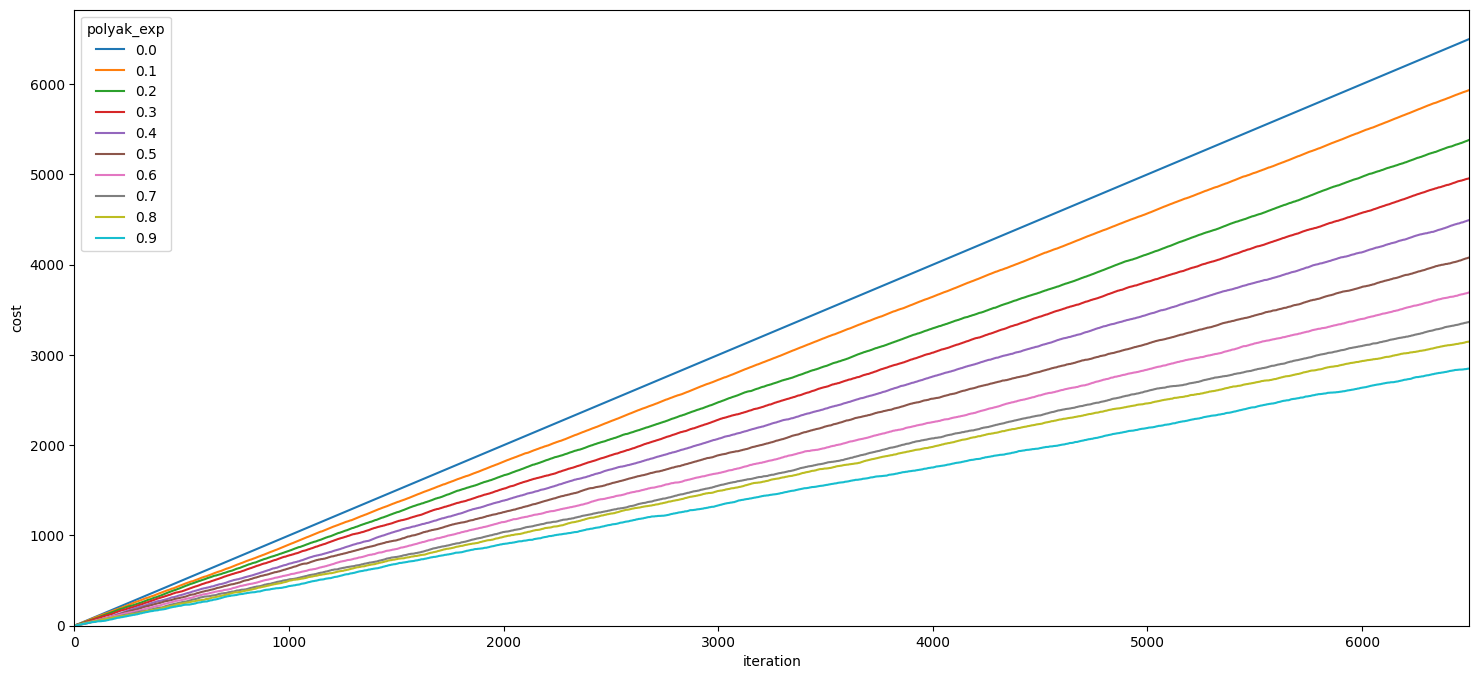

In [65]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="iteration", y="cost", hue="polyak_exp")
ax.set_xlim((0, 6500))
ax.set_ylim(bottom=0)

(0.0, 0.7079462615476301)

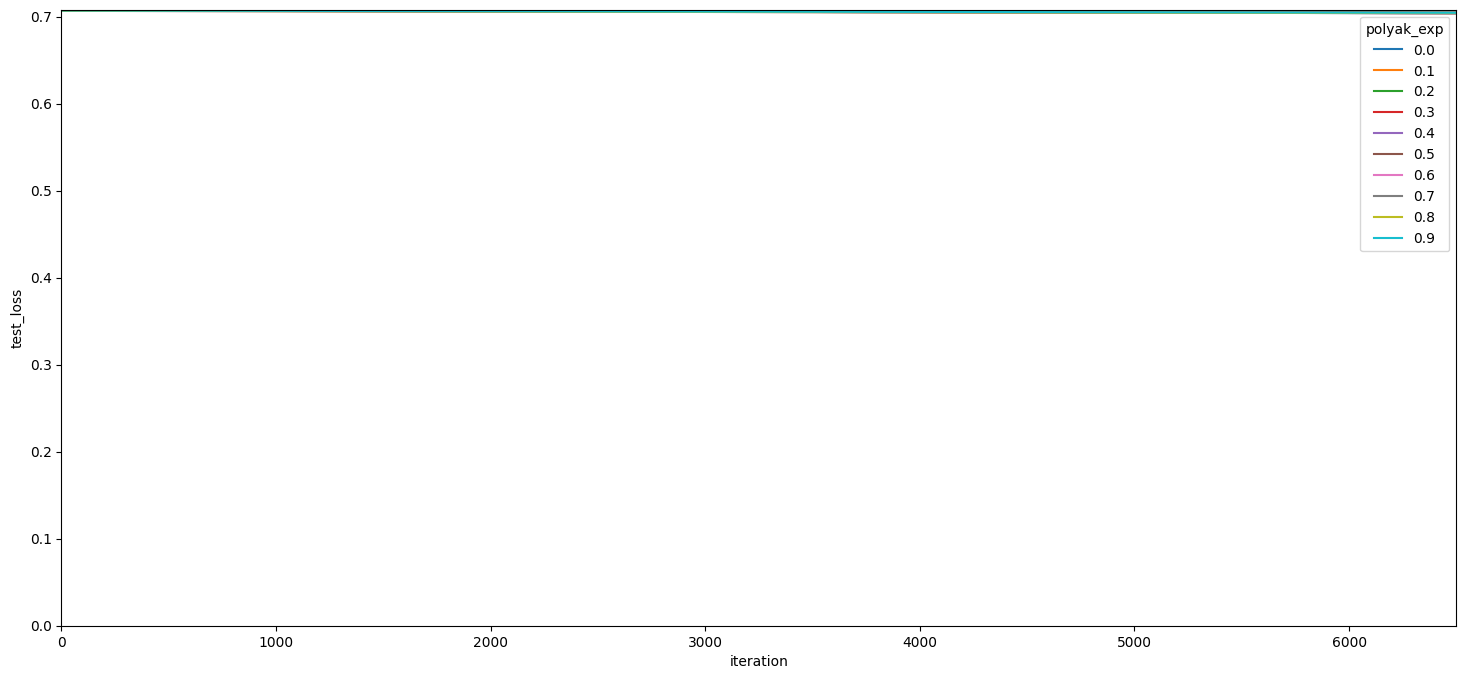

In [66]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="iteration", y="test_loss", hue="polyak_exp")
ax.set_xlim((0, 6500))
ax.set_ylim(bottom=0)

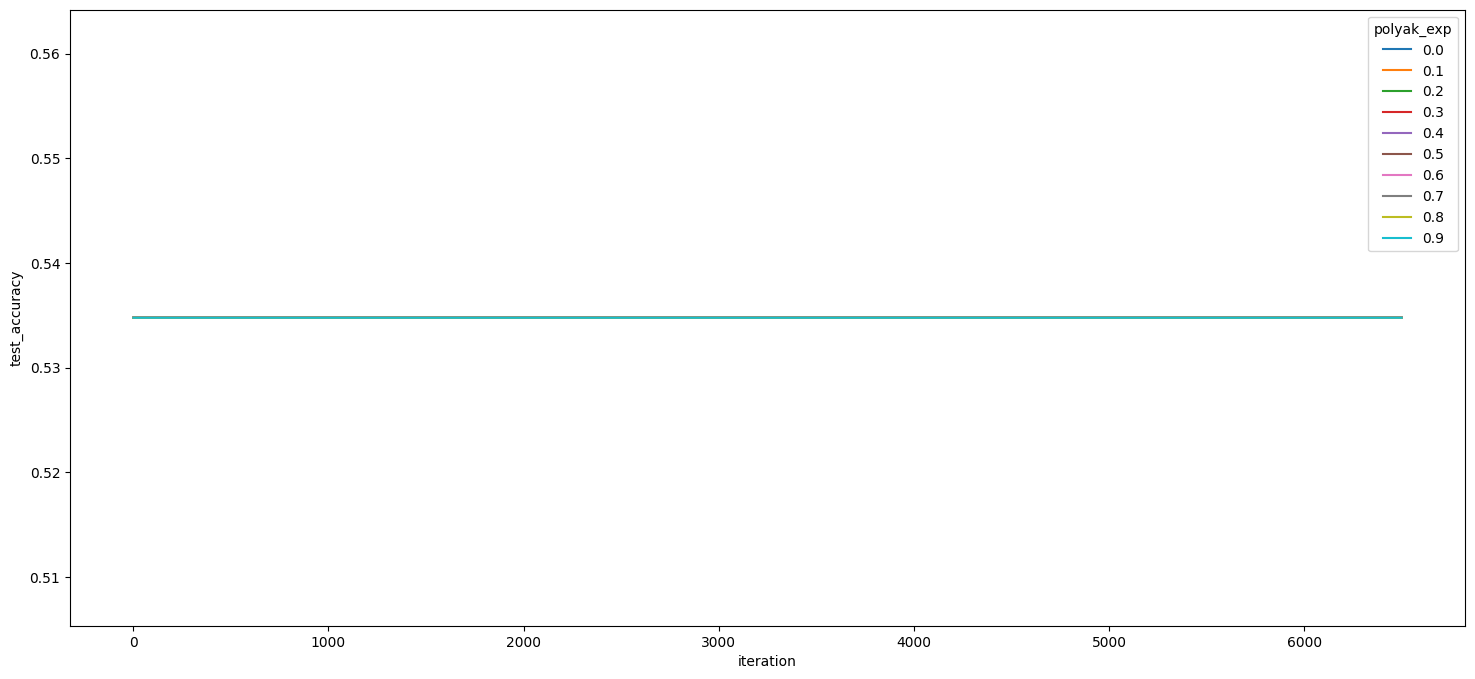

In [67]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="iteration", y="test_accuracy", hue="polyak_exp")

(0.0, 4000.0)

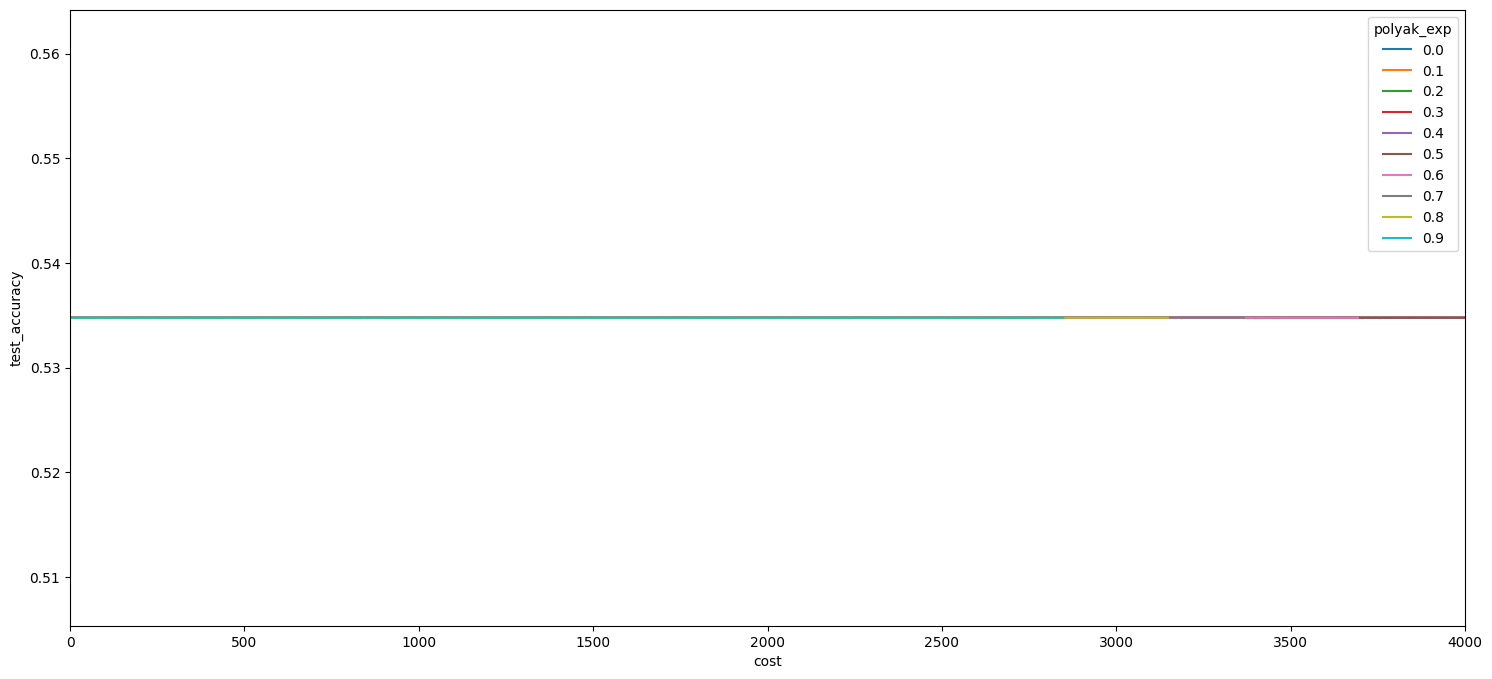

In [68]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="cost", y="test_accuracy", hue="polyak_exp")
ax.set_xlim((0, 4000))

(0.0, 0.7079462615476301)

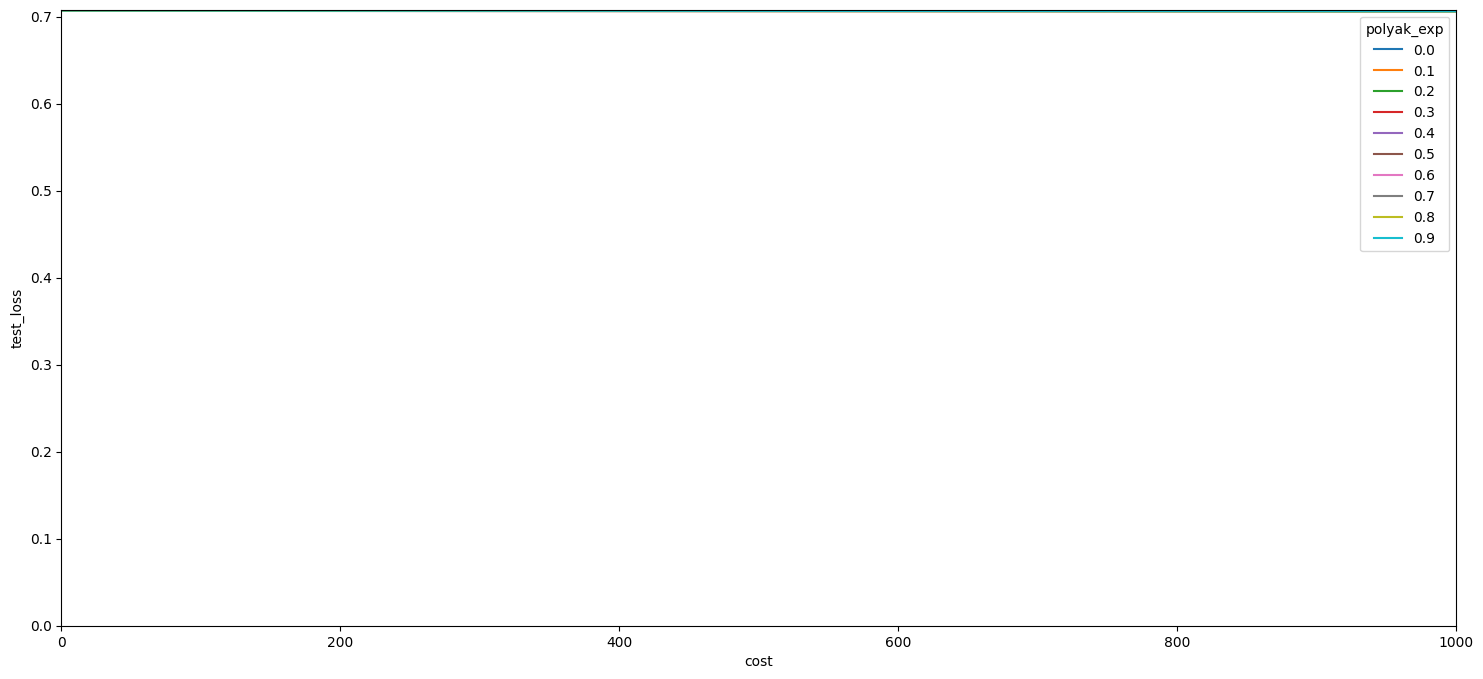

In [69]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="cost", y="test_loss", hue="polyak_exp")
ax.set_xlim((0, 1000))
ax.set_ylim(bottom=0)

## Make comparison plots

In [70]:
df_test_losses["method"] = "polyak_absloss"

import re
df_test_losses_rand = pd.DataFrame(
    [(re.findall("\d.\d", k)[0], v["labeled"], v["losses_test"], v["accuracies_test"]) 
     for k,v in rand_results.items()]
)


df_test_losses_rand.columns = ["polyak_exp", "labeled", "test_loss", "test_accuracy"]
df_test_losses_rand = df_test_losses_rand.explode(["test_loss", "test_accuracy"])
df_test_losses_rand["iteration"] = df_test_losses_rand.groupby('polyak_exp').cumcount()+1
df_test_losses_rand = df_test_losses_rand.reset_index()
df_test_losses_rand["cost"] = [
    np.sum(labels[:iteration]) for iteration, labels in zip(df_test_losses_rand.iteration, df_test_losses_rand.labeled)
]
df_test_losses_rand["method"] = "rand"


import re
df_test_losses_bec_absloss = pd.DataFrame(
    [(re.findall("\d.\d", k)[0], v["labeled"], v["losses_test"], v["accuracies_test"]) 
     for k,v in becs_absloss_results.items()]
)


df_test_losses_bec_absloss.columns = ["polyak_exp", "labeled", "test_loss", "test_accuracy"]
df_test_losses_bec_absloss = df_test_losses_bec_absloss.explode(["test_loss", "test_accuracy"])
df_test_losses_bec_absloss["iteration"] = df_test_losses_bec_absloss.groupby('polyak_exp').cumcount()+1
df_test_losses_bec_absloss = df_test_losses_bec_absloss.reset_index()
df_test_losses_bec_absloss["cost"] = [
    np.sum(labels[:iteration]) for iteration, labels in zip(df_test_losses_bec_absloss.iteration, df_test_losses_bec_absloss.labeled)
]
df_test_losses_bec_absloss["method"] = "absloss"


import re
df_test_losses_polyak_rand = pd.DataFrame(
    [(re.findall("\d.\d", k)[0], v["labeled"], v["losses_test"], v["accuracies_test"]) 
     for k,v in polyak_rand_results.items()]
)
df_test_losses_polyak_rand.columns = ["polyak_exp", "labeled", "test_loss", "test_accuracy"]
df_test_losses_polyak_rand = df_test_losses_polyak_rand.explode(["test_loss", "test_accuracy"])
df_test_losses_polyak_rand["iteration"] = df_test_losses_polyak_rand.groupby('polyak_exp').cumcount()+1
df_test_losses_polyak_rand = df_test_losses_polyak_rand.reset_index()
df_test_losses_polyak_rand["cost"] = [
    np.sum(labels[:iteration]) for iteration, labels in zip(df_test_losses_polyak_rand.iteration, df_test_losses_polyak_rand.labeled)
]
df_test_losses_polyak_rand["method"] = "polyak_rand"

In [71]:
df_test_losses_rand

,index,polyak_exp,labeled,test_loss,test_accuracy,iteration,cost,method
0,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.771652,0.534769,1,1.0,rand
1,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.771634,0.534769,2,2.0,rand
2,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.77161,0.534769,3,3.0,rand
3,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.771586,0.534769,4,4.0,rand
4,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.771561,0.534769,5,5.0,rand
...,...,...,...,...,...,...,...,...
64985,9,0.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.761786,0.534769,6495,623.0,rand
64986,9,0.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.761786,0.534769,6496,623.0,rand
64987,9,0.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.761773,0.534769,6497,624.0,rand
64988,9,0.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.761773,0.534769,6498,624.0,rand


In [72]:
df_test_losses

,index,polyak_exp,labeled,test_loss,test_accuracy,iteration,cost,method
0,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.70723,0.534769,1,1.0,polyak_absloss
1,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.707229,0.534769,2,2.0,polyak_absloss
2,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.707228,0.534769,3,3.0,polyak_absloss
3,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.707227,0.534769,4,4.0,polyak_absloss
4,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.707226,0.534769,5,5.0,polyak_absloss
...,...,...,...,...,...,...,...,...
64985,9,0.9,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...",0.704478,0.534769,6495,2848.0,polyak_absloss
64986,9,0.9,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...",0.704478,0.534769,6496,2848.0,polyak_absloss
64987,9,0.9,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...",0.704478,0.534769,6497,2848.0,polyak_absloss
64988,9,0.9,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...",0.704478,0.534769,6498,2848.0,polyak_absloss


In [73]:
df_test_losses_polyak_rand

,index,polyak_exp,labeled,test_loss,test_accuracy,iteration,cost,method
0,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.711477,0.534769,1,1.0,polyak_rand
1,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.711283,0.534769,2,2.0,polyak_rand
2,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.711091,0.534769,3,3.0,polyak_rand
3,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.710901,0.534769,4,4.0,polyak_rand
4,0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.710713,0.534769,5,5.0,polyak_rand
...,...,...,...,...,...,...,...,...
64985,9,0.9,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...",0.69316,1.0,6495,695.0,polyak_rand
64986,9,0.9,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...",0.69316,1.0,6496,695.0,polyak_rand
64987,9,0.9,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...",0.69316,1.0,6497,695.0,polyak_rand
64988,9,0.9,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...",0.69316,1.0,6498,695.0,polyak_rand


In [74]:
df_test_losses_bec_absloss[df_test_losses_bec_absloss.iteration == 6499]

,index,polyak_exp,labeled,test_loss,test_accuracy,iteration,cost,method
6498,0,0.0,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.721799,1.0,6499,6388.0,absloss
12997,1,0.1,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",0.721809,1.0,6499,5076.0,absloss
19496,2,0.2,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, ...",0.721793,1.0,6499,3954.0,absloss
25995,3,0.3,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...",0.721883,0.998154,6499,3061.0,absloss
32494,4,0.4,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...",0.722691,0.912,6499,2283.0,absloss
38993,5,0.5,"[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...",0.727387,0.698462,6499,1774.0,absloss
45492,6,0.6,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.740237,0.560615,6499,1376.0,absloss
51991,7,0.7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.761218,0.536615,6499,1091.0,absloss
58490,8,0.8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.79793,0.534769,6499,825.0,absloss
64989,9,0.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.833497,0.534769,6499,649.0,absloss


In [75]:
df_test_losses = pd.concat([df_test_losses_rand, df_test_losses_bec_absloss, df_test_losses, df_test_losses_polyak_rand])

In [76]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

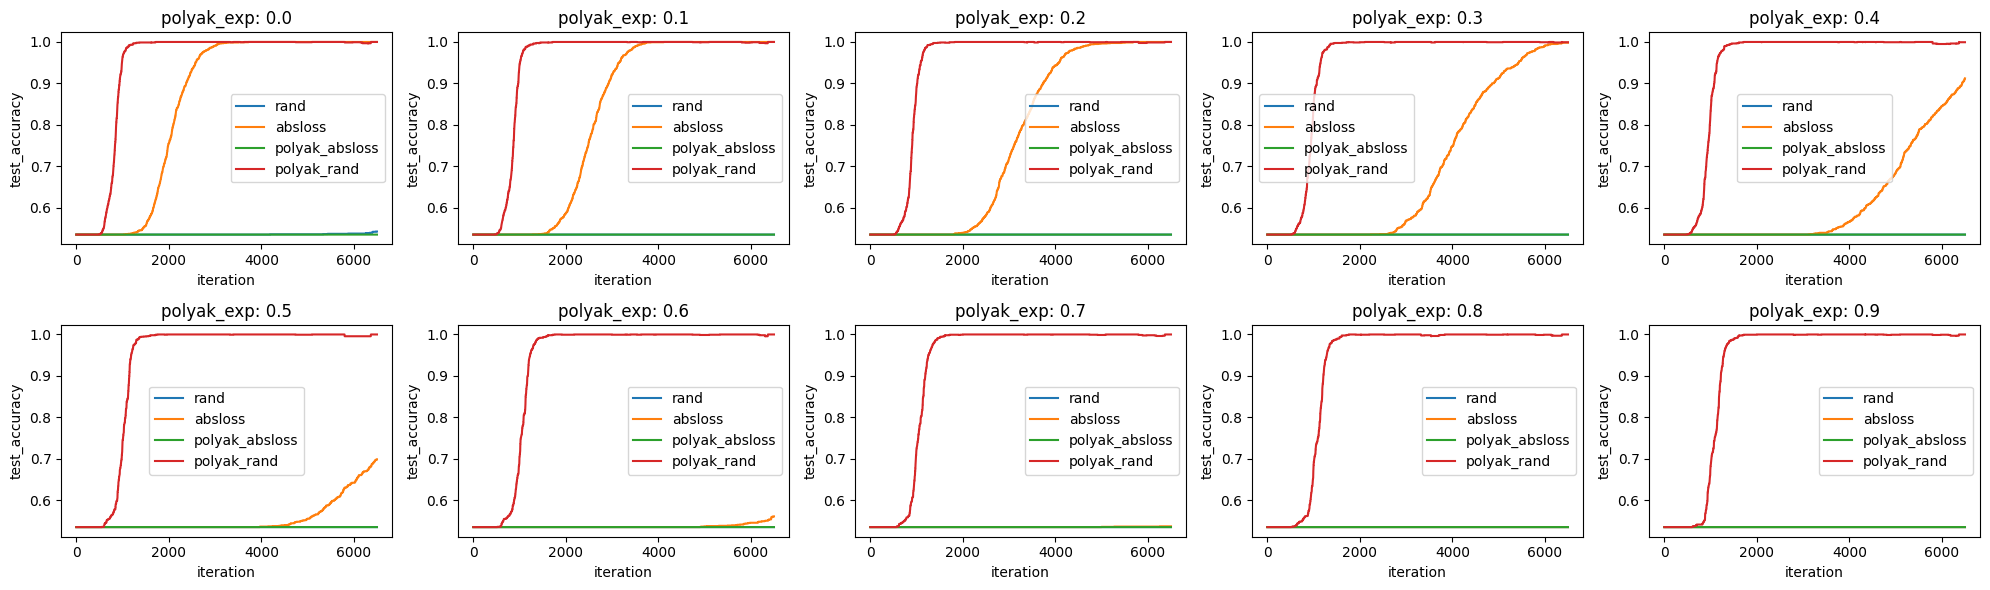

In [77]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="iteration", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"polyak_exp: {polyak_exp}")
    ax.legend()
f.tight_layout()

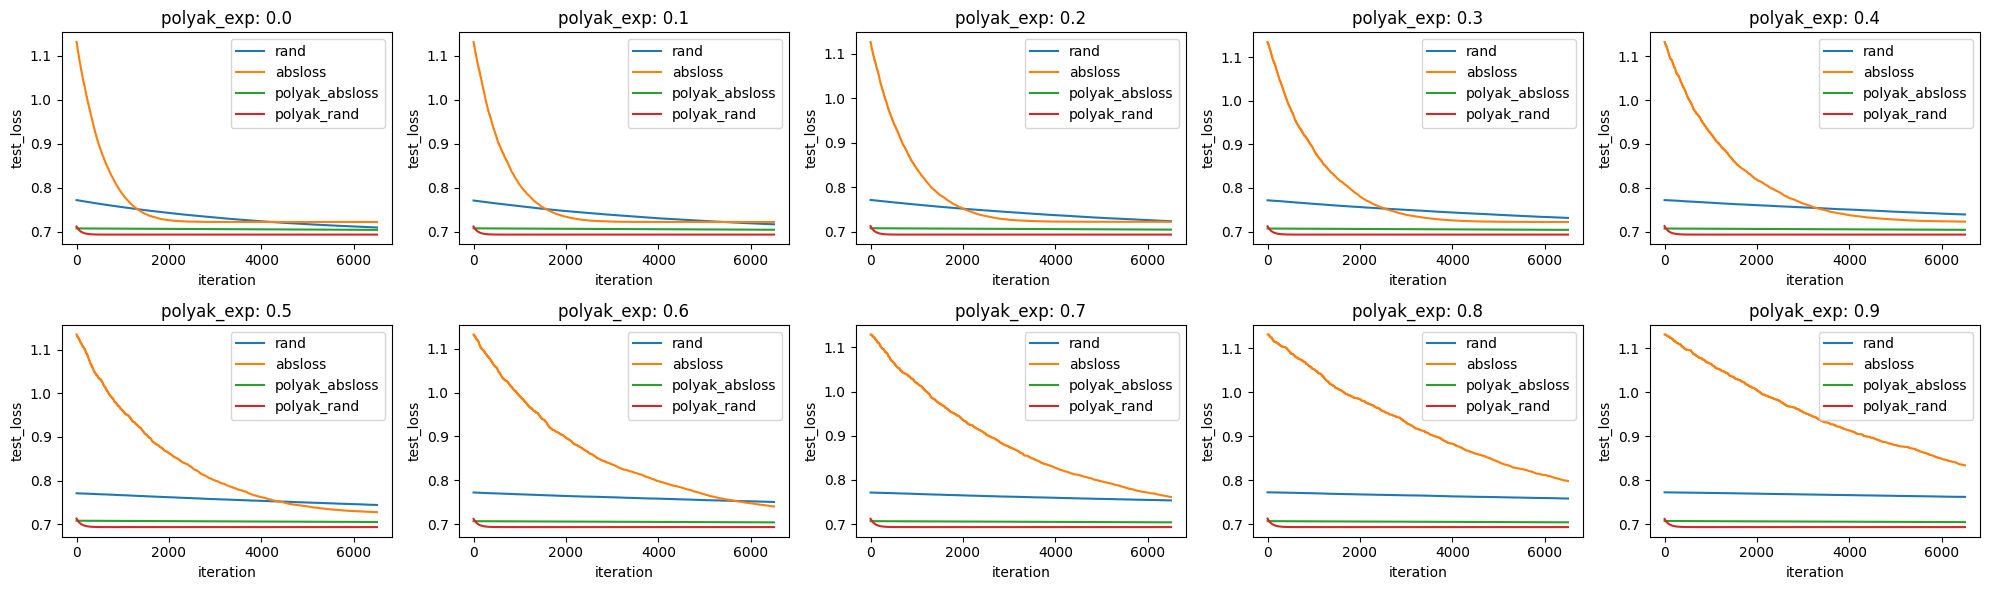

In [78]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="iteration", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"polyak_exp: {polyak_exp}")
    ax.legend()
f.tight_layout()

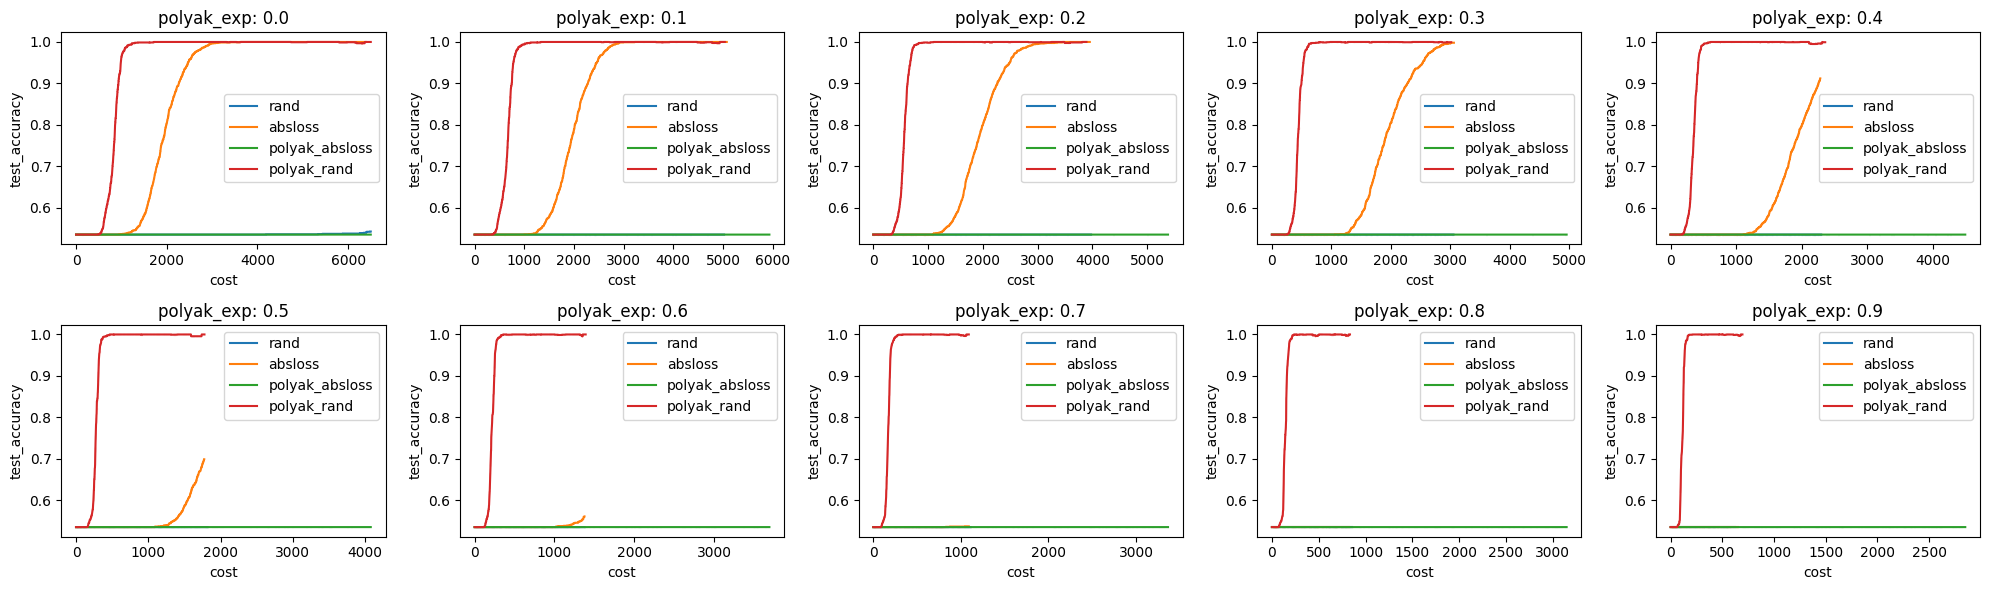

In [79]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="cost", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"polyak_exp: {polyak_exp}")
    ax.legend()
f.tight_layout()

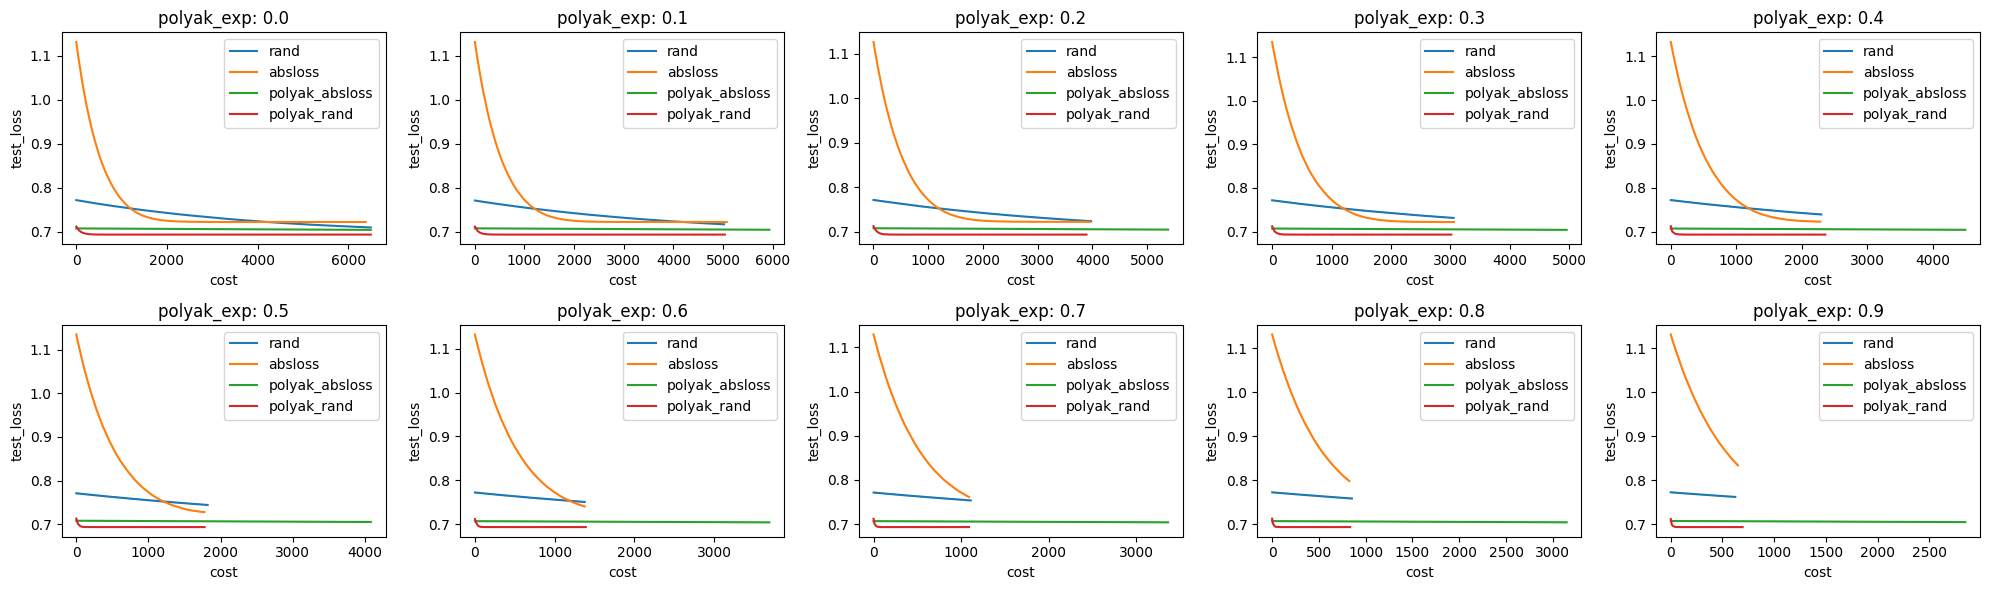

In [80]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="cost", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"polyak_exp: {polyak_exp}")
    ax.legend()
f.tight_layout()

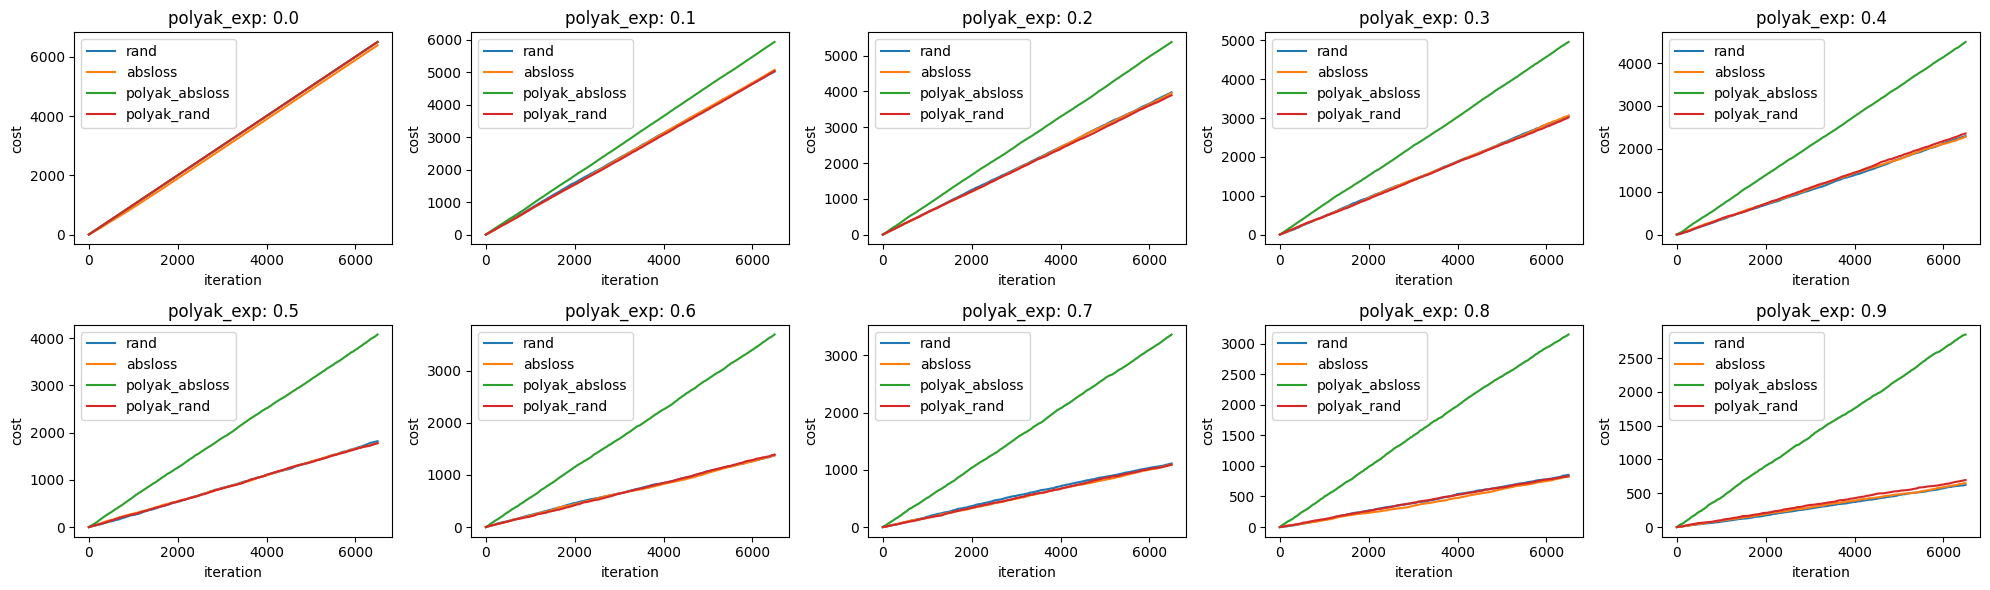

In [81]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="iteration", 
        y="cost", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"polyak_exp: {polyak_exp}")
    ax.legend()
f.tight_layout()

In [92]:
for r in rand_results.keys():
    print(f"{r}: {np.mean(rand_results[r]['probs'])}")


rand_0.0: 1.0
rand_0.1: 0.7745240529580661
rand_0.2: 0.5998875086105891
rand_0.3: 0.46462730448799056
rand_0.4: 0.35986502298701983
rand_0.5: 0.27872411612175435
rand_0.6: 0.2158785320757759
rand_0.7: 0.16720311560996784
rand_0.8: 0.1295028347694484
rand_0.9: 0.10030306045519197


In [93]:
for r in polyak_becs2.keys():
    print(f"{r}: {np.mean(polyak_becs2[r]['probs'])}")


polyak_bec_0.0: 1.0
polyak_bec_0.1: 0.9113999419089074
polyak_bec_0.2: 0.8306498541115597
polyak_bec_0.3: 0.7570542287839177
polyak_bec_0.4: 0.6899791801355551
polyak_bec_0.5: 0.6288469846939002
polyak_bec_0.6: 0.5731311053196123
polyak_bec_0.7: 0.5223516560944824
polyak_bec_0.8: 0.4760712690205329
polyak_bec_0.9: 0.4338913269298131


In [94]:
for r in polyak_rand_results.keys():
    print(f"{r}: {np.mean(polyak_rand_results[r]['probs'])}")

polyak_rand_0.0: 1.0
polyak_rand_0.1: 0.7745240529580661
polyak_rand_0.2: 0.5998875086105891
polyak_rand_0.3: 0.46462730448799056
polyak_rand_0.4: 0.35986502298701983
polyak_rand_0.5: 0.27872411612175435
polyak_rand_0.6: 0.2158785320757759
polyak_rand_0.7: 0.16720311560996784
polyak_rand_0.8: 0.1295028347694484
polyak_rand_0.9: 0.10030306045519197


In [95]:
for r in becs_absloss_results.keys():
    print(f"{r}: {np.mean(becs_absloss_results[r]['probs'])}")


bec-absloss_0.0: 0.9852722993722277
bec-absloss_0.1: 0.7742511523379197
bec-absloss_0.2: 0.5999053780162187
bec-absloss_0.3: 0.4647750626651881
bec-absloss_0.4: 0.35937128345142466
bec-absloss_0.5: 0.2783003607130997
bec-absloss_0.6: 0.21553554539112413
bec-absloss_0.7: 0.1671225707342524
bec-absloss_0.8: 0.12943031115014186
bec-absloss_0.9: 0.10013479814421547
